 # <ins>"Исследование критериев успешности компьютерных игр"</ins>
___

**Содержание**
___
<a id='top'></a>
1. [Исходные данные](#Исходные-данные)
2. [Постановка задачи](#Постановка-задачи)
3. [Получение данных](#Получение-данных)
4. [Предварительная обработка данных](#Предварительная-обработка-данных)
5. [Расчет дополнительных параметров](#Расчет-дополнительных-параметров)
6. [Исследовательский анализ данных](#Исследовательский-анализ-данных)
7. [Факторы влияния на стоимость объекта](#Факторы-влияния-на-стоимость-объекта)
8. [Выводы](#Выводы)


## Исходные данные

Интернет-магазине **«Стримчик»**, продающий по всему миру компьютерные игры планирует свою работу в 2017г. Из открытых источников доступны исторические данные о продажах игр до 2016 года, оценки пользователей и экспертов, жанры и платформы. 

Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Постановка задачи

Необходимо выявить определяющие успешность игры закономерности и спланировать рекламные кампании магазина на 2017г.

## Получение данных

* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за **2016** год могут быть неполными.

In [335]:
# Импортируем необходимые библиотеки
import warnings

# Аналитика
import pandas as pd
import numpy as np

# Графики
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Статистика
from scipy import stats as st

In [336]:
# mpl.rc_params()

In [337]:
# Загужаем датасет
try:
    data = pd.read_csv(r'D:\Local Python Project\Ya_praktikum\datasets\games.csv')
except FileNotFoundError:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [338]:
# Задаем размер объектов графиков
width = 12
height = 4

In [339]:
# Задаем глобальные настройки графиков
graph_set = {'figure.figsize': (width, height),
             'axes.grid.axis': 'y',
             'axes.facecolor': 'ivory',
             'axes.edgecolor': 'grey',
             'axes.linewidth': .5, 
             'grid.color': 'gray', 
             'grid.linestyle': ':',
             'grid.linewidth': 0.4,
             'font.size': 12.0,
             'axes.titlecolor': 'gray',
             'axes.titleweight': 'bold'}

bar_color = 'tab:blue'

fd_16 = {'size': 16, 'weight': 'bold', 'color': 'gray'}
fd_10 = {'size': 10, 'weight': 'bold', 'color': 'gray'}

In [340]:
# Вносим изменения в настройки графиков
for k, v in graph_set.items():
    mpl.rcParams[k] = v

In [341]:
# Устанавливаем формат вывода чисел
pd.options.display.float_format = '{:20,.2f}'.format

# Отклюаем предупреждения
warnings.simplefilter(action='ignore')

In [342]:
# Создадим функцию для первичной оценки датасета
def fast_eda(data, row_num=5):
    print(f'Общая информация по датасету:')
    print()
    print(data.info())
    print()
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print()
    display(data.head(row_num))

In [343]:
fast_eda(data)

Общая информация по датасету:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Количество дубликатов: 0



,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [344]:
# Создадим функцию для рисования быстрых гистограмм
def fast_hist(data, h_size, v_size, color, width=12, height=4):
    
    # Строим быстрые гистограммы
    fast_hist = data.hist(figsize=(width, height * v_size), 
                          color=color,
                          alpha=.75,
                          edgecolor='black',
                          linewidth=.5, 
                          layout=(v_size, h_size))

    # Настраиваем отображение
    for i, ax in enumerate(fast_hist.flatten()):

        if i % 3 == 0:
            ax.set_ylabel('Количество', fontdict=fd_10)
        ax.grid(axis='x')
        ax.tick_params(axis='both', labelsize=8)

In [345]:
# Зададим размеры координатной сетки для графиков
h_size = 3
v_size = 4

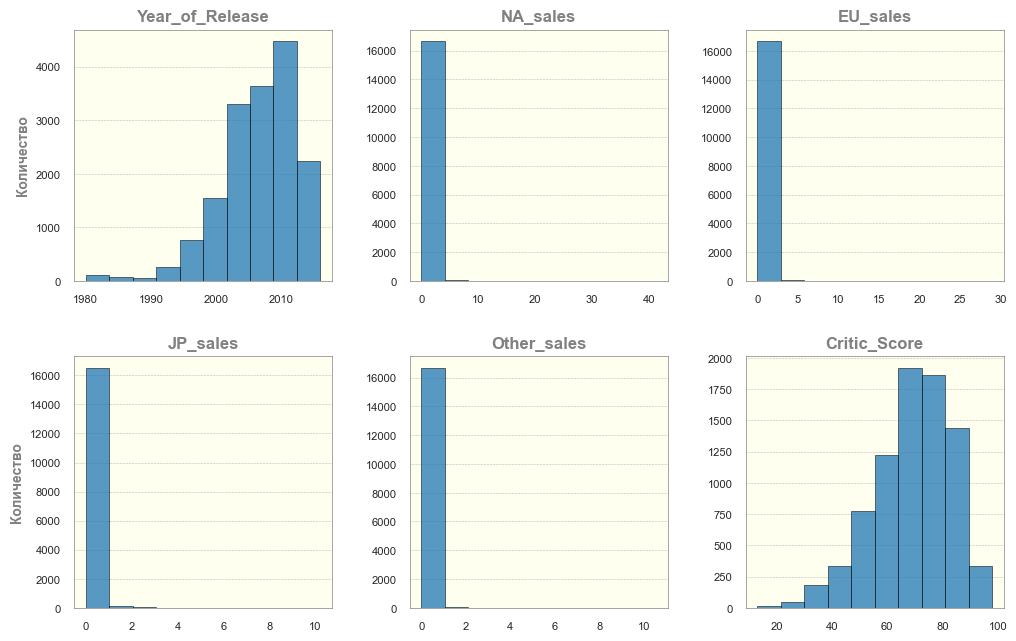

In [346]:
fast_hist(data, h_size=h_size, v_size=v_size, color=bar_color)

**Выводы:**
1. В датасете имеются пропущенные значения, необходимо их обработать.
2. Для удобства привести названия столбцов к нижнему регистру.
3. Привести столбцы к более уместному формату данных.
4. В датасете отсутствуют явные дубликаты.

## Предварительная обработка данных

### Переименование названий колонок

Названия столбцов адекватно отражают их содержание, ограничимся переводом в нижний регистр для удобства

In [347]:
# Переведем названия столбцов в нижний регистр
data.columns = data.columns.str.lower()

In [348]:
# Проверяем результат
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Дополнительно проверим на наличие неявных дубликатов по столбцам `name` и `platform`.

In [349]:
data[data.duplicated(subset=['name', 'platform'], keep=False)].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.5,E
1190,Need for Speed: Most Wanted,X360,"2,012.00",Racing,0.62,0.78,0.01,0.15,83.00,8.5,T
1591,Need for Speed: Most Wanted,X360,"2,005.00",Racing,1.00,0.13,0.02,0.10,83.00,8.5,T
5972,Need for Speed: Most Wanted,PC,"2,005.00",Racing,0.02,0.23,0.00,0.04,82.00,8.5,T
11715,Need for Speed: Most Wanted,PC,"2,012.00",Racing,0.00,0.06,0.00,0.02,82.00,8.5,T
1745,Sonic the Hedgehog,PS3,"2,006.00",Platform,0.41,0.06,0.04,0.66,43.00,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.00,4.1,E10+
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Выявлено **5** строк, проверим этот список.

In [350]:
data[data['name'].isin(data[data.duplicated(subset=['name', 'platform'])]['name'])].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,"2,012.00",Sports,0.00,0.01,0.00,0.00,83.00,5.5,E
7066,Madden NFL 13,WiiU,"2,012.00",Sports,0.21,0.00,0.00,0.02,75.00,6.7,E
507,Madden NFL 13,X360,"2,012.00",Sports,2.53,0.15,0.00,0.17,81.00,5.8,E
604,Madden NFL 13,PS3,"2,012.00",Sports,2.11,0.22,0.00,0.23,83.00,5.5,E
5887,Madden NFL 13,PSV,"2,012.00",Sports,0.28,0.00,0.00,0.02,63.00,7.3,E
3986,Madden NFL 13,Wii,"2,012.00",Sports,0.47,0.00,0.00,0.03,NaN,7.3,E
6473,Need for Speed: Most Wanted,GBA,"2,005.00",Racing,0.19,0.07,0.00,0.00,NaN,8.3,E
6410,Need for Speed: Most Wanted,DS,"2,005.00",Racing,0.24,0.01,0.00,0.02,45.00,6.1,E
6273,Need for Speed: Most Wanted,WiiU,"2,013.00",Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
5972,Need for Speed: Most Wanted,PC,"2,005.00",Racing,0.02,0.23,0.00,0.04,82.00,8.5,T


1. **Madden NFL 13**. Указан дважды для платформы **PS3**, явное задвоение, совпадают рейтинги критиков и пользователей, однако в столбце `eu_sales` есть данные о продажах , прибавим эти данные к основной записи, после дубль удалим.
2. **Need for Speed: Most Wanted**. В данном случае задвоения нет. Игра вышла в **2005 г**., а в **2013 г**. перевыпущена под тем же названием, оставляем как есть.
3. **Sonic the Hedgehog**. В одной из записей не указана дата релиза, явное задвоение, совпадают рейтинги критиков и пользователей, возможно это послужило причиной задвоения, есть данные в столбце `eu_sales`, возможно это ошибка при формировании датасета см. п.1. Прибавим эти данные к основной записи после дубль удалим.
4. Две записи с отсутствующим название, платформой, обработаем эти строки в следующем разделе.

In [351]:
# Удаляем дубли для игр 'Madden NFL 13' и 'Sonic the Hedgehog'
data = data.drop(index=[4127, 16230]).reset_index(drop=True)

In [352]:
# Для игр 'Madden NFL 13' и 'Sonic the Hedgehog' переносим данные в основную запись
data = data.drop(index=4127).reset_index(drop=True)
data.loc[(data['name'] == 'Sonic the Hedgehog') & (data['platform'] == 'PS3'), 'eu_sales'] = 0.54
data.loc[(data['name'] == 'Madden NFL 13') & (data['platform'] == 'PS3'), 'eu_sales'] = 0.16

In [353]:
data.shape

(16712, 11)

### Обработка столбца `name`

In [354]:
# Проверим наличие пропусков
data['name'].isna().sum()

2

Выведем эти строки на экран.

In [355]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,"1,993.00",NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14242,NaN,GEN,"1,993.00",NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В записях нет жанра, оценок и рейтинга, отсутствует название, за него можно было бы зацепиться. Чем-либо заместить эти данные невозможно, эти строки придется удалить.

Причиной появления пропусков в данных строках может быть ошибка при выгрузке или ошибка самой базы данных откуда эта выгрузка осуществлялась.

In [356]:
# Удаляем пропуски, сбрасываем индексы
data = data.dropna(subset=['name']).reset_index(drop=True)

In [357]:
# Проверяем результат
data['name'].isna().sum()

0

### Обработка столбца `platform`

In [358]:
# Проверим наличие пропусков
data['platform'].isna().sum()

0

Пропусков нет, проверим на наличие неявных дубликатов.

In [359]:
data.groupby('platform').agg(data=('name', 'count'))

,data
platform,
2600,133
3DO,3
3DS,520
DC,52
DS,2151
GB,98
GBA,822
GC,556
GEN,27


Неявных дубликатов не обнаружено.

### Обработка столбца `year_of_release`

In [360]:
# Проверяем наличие пропусков
data['year_of_release'].isna().sum()

268

Посмотрим на эти строки.

In [361]:
data[data['year_of_release'].isna()].sample(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15018,Umineko no Naku Koro ni San: Shinjitsu to Gens...,PS3,NaN,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN
16176,WRC: FIA World Rally Championship,PC,NaN,Racing,0.00,0.01,0.00,0.00,65.00,NaN,RP
1608,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,0.69,0.42,0.00,0.12,76.00,7.8,E10+
14138,Major League Baseball 2K8,PSP,NaN,Sports,0.03,0.00,0.00,0.00,63.00,tbd,E
5067,The Golden Compass,PSP,NaN,Action,0.11,0.16,0.00,0.10,28.00,4.1,E10+
3412,Madden NFL 06,X360,NaN,Sports,0.54,0.00,0.01,0.03,74.00,4.9,E
10047,Star Trek: Conquest,PS2,NaN,Strategy,0.06,0.04,0.00,0.01,54.00,9.1,E
7388,Valkyria Chronicles III: Unrecorded Chronicles,PSP,NaN,Strategy,0.00,0.00,0.21,0.00,NaN,NaN,NaN
15075,Payout Poker & Casino,PSP,NaN,Misc,0.02,0.00,0.00,0.00,NaN,NaN,NaN
6296,Flag Capture,2600,NaN,Action,0.25,0.02,0.00,0.00,NaN,NaN,NaN


Год выпуска является категориальной переменной соотвественно заполнять средней или медианой нельзя. Попоробуем спасти часть данных взяв год выпуска из названия игры.

Причиной отсутствия данных в столбце `year_of_release` может быть ошибка базы данных, либо ошибка допущена при выгрузке.

In [362]:
# Создаем функцию
def get_year(data):
    
    # Обычно год пишут в конце названия, разрезаем строку по пробелу берем только последний элемент образовавшегося списка
    year_string = data['name'].split()[-1]

    # Из полученного результатата вычитаем 1, т.к. обычно разработчики выпускают игру минус 1 год от указанного в названии.

    # Обрабатываем строки вида 2К10, 2К5, 2К в которых год указан в формате 2К,
    # проверяем отсутствие данных в столбце 'year_of_release'
    if '2K' in year_string and np.isnan(data['year_of_release']):
        if year_string == '2K':
            return 2000 - 1

        elif len(year_string) == 4:
            year_string = year_string.replace('K', '0')
            return float(year_string) - 1

        elif len(year_string) == 3:
            year_string = year_string.replace('K', '00')
            return float(year_string) - 1

    # Обрабатываем 4-х символьные числовые строки, переводим в число и вычитаем 1.
    # Проверяем отсутствие данных в столбце 'year_of_release'
    elif year_string.isdigit() and len(year_string) == 4 and np.isnan(data['year_of_release']):
        return float(year_string) - 1

    # Обрабатываем 2-x символьные числовые строки, дописываем век, переводим в число и вычитаем 1.
    # Проверяем отсутствие данных в столбце 'year_of_release'
    elif year_string.isdigit() and len(year_string) == 2 and np.isnan(data['year_of_release']):

        # В датасете период данных с 1980 по 2016, определяем в каком веке выпущена игра по первой цифре
        # Для игр выпущенных в начале 21 века добавляем 20
        if int(year_string[0]) == 0 or int(year_string[0]) == 1:
            year_string = '20' + year_string
            return float(year_string) - 1
        
        # Для игр выпущенных в конце 20 века добавляем 19
        elif int(year_string[0]) >= 8:
            year_string = '19' + year_string
            return float(year_string) - 1

    # Для строк, где год указан, возвращем его.
    else:
        return data['year_of_release']

In [363]:
data['year_of_release'] = data.apply(get_year, axis=1)

In [364]:
data['year_of_release'].isna().sum()

245

Спасено **23** строки, для мультиплатфоренных игр предлагается проверить наличие данных о годе выпуска в строках для разных платформ. Отметим, что восстановление данных о годе релиза таким способом может создать аномалии т.к. одна играм может выходить на одной платформе разных поколений. Учитывая, что таких строк небольшое количество это не окажет сильного влияния на результаты анализа, но позволит сохранить данные. Учтем это при дальнейшем анализе.

In [365]:
data['year_of_release'] = data['year_of_release']. \
    fillna(data.groupby('name')['year_of_release'].transform('max'))

In [366]:
# Проверяем результат
data['year_of_release'].isna().sum()

138

На этапе Исследования данных выявились аномалии и ошибки в данных, о которых писали выше, вносим исправления вручную.

In [367]:
data.loc[(data['name'] == 'Wheel of Fortune') & (data['platform'] == 'PS2'), 'year_of_release'] = 2000

In [368]:
data.loc[(data['name'] == 'WRC: FIA World Rally Championship') & (data['platform'] == 'PS3'), 'year_of_release'] = 2006

In [369]:
data.loc[data['name'] == 'Strongest Tokyo University Shogi DS', 'year_of_release'] = 2004

In [370]:
data.loc[(data['name'] == 'Mario Tennis') & (data['platform'] == '3DS'), 'year_of_release'] = 2010

In [371]:
data.loc[(data['name'] == 'Space Invaders') & (data['platform'] == '2600'), 'year_of_release'] = 1989

Осталось **138** строк с пропущенной датой релиза, менее **1%** от всего датасета, удалим эти строки.

In [372]:
# Проверяем результат
data.shape

(16710, 11)

In [373]:
# Удаляем строки с пропусками
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)

In [374]:
# Проверяем результат
data.shape

(16572, 11)

In [375]:
# Переводим столбец в формат данных целое число
data['year_of_release'] = data['year_of_release'].astype('int16')

In [376]:
# Проверяем результат
data['year_of_release'].isna().sum()

0

### Обработка столбца `genre`

In [377]:
# Проверим столбец на наличие пропусков
data['genre'].isna().sum()

0

In [378]:
# Проверим столбец на наличие неявных дубликатов
data.groupby('genre').agg(data=('genre', 'count'))

,data
genre,
Action,3342
Adventure,1294
Fighting,843
Misc,1735
Platform,878
Puzzle,572
Racing,1238
Role-Playing,1484
Shooter,1311


В столбце `genre` нет необходимости в каких-либо корректировках.

### Обработка столбцов `na_sales`, `eu_sales`, `jp_sales`

Пропусков данных в столбцах нет, посмотрим описание столбцов.

In [379]:
data[['na_sales', 'eu_sales', 'jp_sales']].describe()

,na_sales,eu_sales,jp_sales
count,"16,572.00","16,572.00","16,572.00"
mean,0.26,0.15,0.08
std,0.82,0.51,0.31
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.08,0.02,0.00
75%,0.24,0.11,0.04
max,41.36,28.96,10.22


Явных аномалий нет, обращает на себя внимание большое количество нулевых значений и низкое значение медиан. Проверим эти строки.

In [380]:
data[data['na_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,0.00,0.00,4.87,0.00,NaN,NaN,NaN
340,Friend Collection,DS,2009,Misc,0.00,0.00,3.67,0.00,NaN,NaN,NaN
385,Monster Hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,NaN
403,English Training: Have Fun Improving Your Skills!,DS,2006,Misc,0.00,0.99,2.32,0.02,NaN,NaN,NaN
428,Dragon Quest VI: Maboroshi no Daichi,SNES,1995,Role-Playing,0.00,0.00,3.19,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16566,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN
16567,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16568,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16569,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN


In [381]:
data[data['eu_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
148,Final Fantasy XII,PS2,2006,Role-Playing,1.88,0.00,2.33,1.74,92.00,7.6,T
215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,0.00,0.00,4.87,0.00,NaN,NaN,NaN
268,Metal Gear Solid 3: Snake Eater,PS2,2004,Action,1.46,0.00,0.83,1.93,91.00,9.3,M
284,Half-Life,PC,1997,Shooter,4.03,0.00,0.09,0.00,96.00,9.1,M
316,Dragon Warrior III,NES,1988,Role-Playing,0.10,0.00,3.77,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16566,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,0.00,0.00,0.00,0.00,NaN,NaN,NaN
16567,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16569,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16570,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [382]:
data[data['other_sales'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
138,World of Warcraft,PC,2004,Role-Playing,0.08,6.21,0.00,0.00,93.00,7.3,T
215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,0.00,0.00,4.87,0.00,NaN,NaN,NaN
284,Half-Life,PC,1997,Shooter,4.03,0.00,0.09,0.00,96.00,9.1,M
288,World of Warcraft: The Burning Crusade,PC,2007,Role-Playing,2.57,1.52,0.00,0.00,91.00,7.9,T
316,Dragon Warrior III,NES,1988,Role-Playing,0.10,0.00,3.77,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16567,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16568,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16569,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16570,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Причин появления нулевых значений может быть несколько:


1. Нет данных, указали **0**.
2. Игра не продавалась в определенном регионе.

Заполнять пропуски средним и медианой в данном случае некорректно т.к это может оказать сильное влияние на результаты анализа. Предлагается оставить данные как есть.

### Обработка столбца `critic_scores`

In [383]:
# Проверим наличие пропусков
data['critic_score'].isna().sum()

8496

In [384]:
# Проверим свойства столбца
data['critic_score'].describe()

count               8,076.00
mean                   68.99
std                    13.92
min                    13.00
25%                    60.00
50%                    71.00
75%                    79.00
max                    98.00
Name: critic_score, dtype: float64

Пропусков в это столбце больше **50%**, причины отсутствия данных могут быть в том, что рейтинговые агрегаторы игр появились гораздо позже самих игр и многие игры не имеют такой оценки, либо данные потеряны при выгрузке
Оценим количество пропусков по годам, построим гистограмму.

In [385]:
critic_score = data.pivot_table(index='year_of_release', values=['critic_score', 'name'], aggfunc=['count']).reset_index()
critic_score.columns = ['year', 'score', 'total']
critic_score['ratio'] = (critic_score['score'] / critic_score['total']) * 100

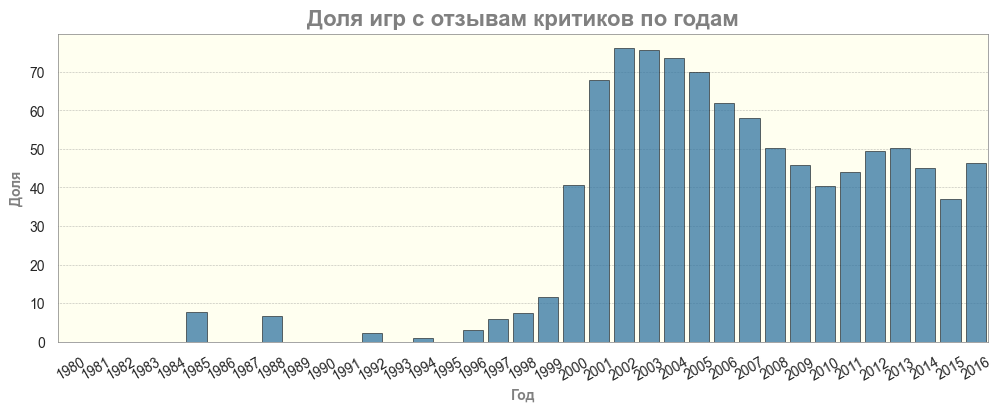

In [386]:
# Рисуем график
ax = sns.barplot(data=critic_score, 
                 x='year', 
                 y='ratio',
                 color=bar_color,
                 alpha=.75,  
                 linewidth=.5, 
                 edgecolor='black')

ax.tick_params(axis='x', rotation=30)

# Настраиваем параметры отображения
ax.set_title('Доля игр с отзывам критиков по годам', fontdict=fd_16)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Доля', fontdict=fd_10)
ax.set_xlabel('Год', fontdict=fd_10) ;

График подтверждает предположение, доля игр с оценкой критиков начинает возрастать только с **2000 г**. и выходит на пик в **2002 - 2003 гг**.

Пойдем по пути заполнения пропусков как в столбце год релиза. Проверим наличие оценки критиков для одной и той же игры у разных платформ. Отметим, что оценки одной игры для разных платформ могут отличаться, для заполнения **Nan** в основном датафрейме возьмем среднюю оценку по игре.

In [387]:
# Выполняем замену пропущенных значений в основном датафрейме
data['critic_score'] = data['critic_score'].\
    fillna(data.groupby(by=['name'])['critic_score'].transform('mean'))

In [388]:
# Проверяем результат
data['critic_score'].isna().sum()

7536

Заполнили **960** строк. Заполнять оставшиеся пропуски средним, медианой или нулями некорректно т.к. это может сильно повлиять на результаты анализа, предлагается оставить как есть.

### Обработка столбца `user_score`

In [389]:
data['user_score'].isna().sum()

6637

В столбце большое количество пропусков, кроме того столбец является строковым, возможно есть какие-то строковые значения. Проверим это предположение

In [390]:
data[~data['user_score'].isna() & data['user_score'].str.isalpha()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.00,0.66,42.00,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.00,0.54,61.00,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.00,0.27,NaN,tbd,T
644,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.00,tbd,E
715,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.00,0.18,NaN,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16552,Planet Monsters,GBA,2001,Action,0.01,0.00,0.00,0.00,67.00,tbd,E
16554,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.00,tbd,E
16555,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.00,tbd,E
16561,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,tbd,E


Столбец заполнен аббревиатурой **tbd**, что в переводе с английского означает *будет определено*, но на текущий момент данных нет, поэтому предлагается заменить на **Nan**. Дальнейшую обработку пропусков в столбце выполнить по схеме со столбцом `critic_score`.

In [391]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

In [392]:
data['user_score'].isna().sum()

9032

Пропусков стало больше примерно на **30%**, попробуем обработать.

In [393]:
# Переведем столбец в числовой формат
data['user_score'] = data['user_score'].astype('float16')

Скорее всего распределение отзывов будет таким же как и у критиков. Причина появления пропусков - отстутсвие агрегаторов собирающих отзывы и оценки критиков в актуальный период жизни игр, либо данные потеряны при выгрузке.

In [394]:
# Формируем сводную таблицу и переводим ее в датафрейм
user_score = data.pivot_table(index='year_of_release', \
                              values=['user_score', 'name'], aggfunc=['count']).reset_index()

# Для удобства переименовываем столбцы
user_score.columns = ['year', 'total', 'score']

# Добавляем столбец с долей отзывов от общего количества игр за год
user_score['ratio'] = (user_score['score'] / user_score['total']) * 100

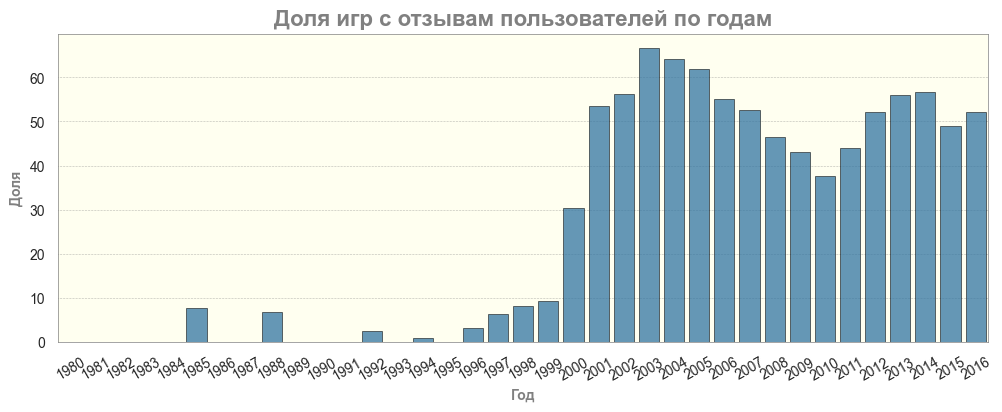

In [395]:
# Рисуем график
ax = sns.barplot(data=user_score, 
                 x='year', 
                 y='ratio',
                 color=bar_color,
                 alpha=.75,  
                 linewidth=.5, 
                 edgecolor='black')

ax.tick_params(axis='x', rotation=30)

# Настраиваем параметры отображения
ax.set_title('Доля игр с отзывам пользователей по годам', fontdict=fd_16)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Доля', fontdict=fd_10) 
ax.set_xlabel('Год', fontdict=fd_10) ;

Обработку пропусков выполним по тому же принципу, что и в столбце `critic_score`, возьмем отсуствующие оценки с других платформ.

In [396]:
# Выполняем замену пропущенных значений в основном датафрейме
data['user_score'] = data['user_score'].\
    fillna(data.groupby(by=['name'])['user_score'].transform('mean'))

Заполнили **767** строк. Заполнять оставшиеся пропуски средним, медианой или нулями некорректно т.к. это может сильно повлиять на результаты анализа, предлагается оставить как есть.

### Обработаем столбец `rating`

In [397]:
# Проверим наличие пропусков
data['rating'].isna().sum()

6704

Пропусков много, причина скорее всего таже, что и в столбцах `critic_score`, `user_score`, проверим предположение.

In [398]:
# Формируем сводную таблицу и переводим ее в датафрейм
rating = data.pivot_table(index='year_of_release', \
                          values=['rating', 'name'], aggfunc=['count']).reset_index()

# Для удобства переименовываем столбцы
rating.columns = ['year', 'total', 'score']

# Добавляем столбец с долей отзывов от общего количества игр за год
rating['ratio'] = (rating['score'] / rating['total']) * 100

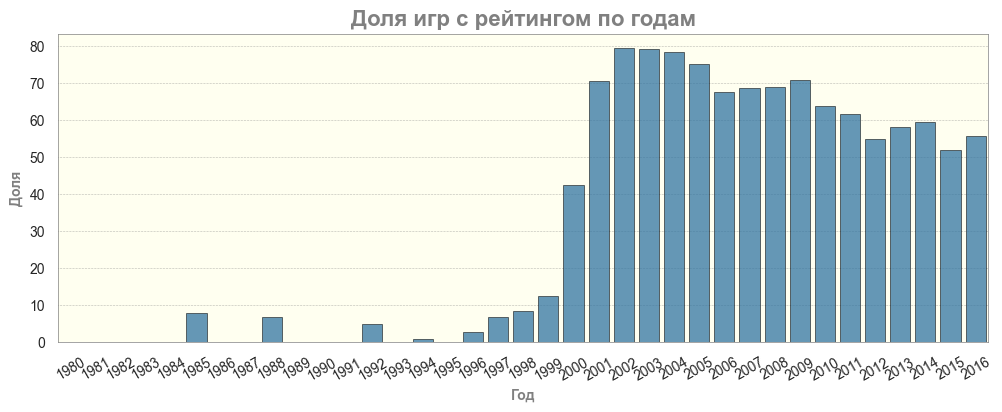

In [399]:
# Рисуем график
ax = sns.barplot(data = rating, 
                 x = 'year', 
                 y = 'ratio',
                 color=bar_color,
                 alpha=.75,  
                 linewidth=.5, 
                 edgecolor='black')

ax.tick_params(axis='x', rotation=30)

# Настраиваем параметры отображения
ax.set_title('Доля игр с рейтингом по годам', fontdict=fd_16)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Доля', fontsize=10, fontdict=fd_10) 
ax.set_xlabel('Год', fontsize=10, fontdict=fd_10) ;

График демонстрирует, доли игр с отсутствующим рейтингом в разные годы разняться, вероятней всего причина отсутствия рейтинга это комбинация факторов. Как отсутствие рейтинга, ошибка при выгрузке, ошибка базы данных.

Попробуем избавиться от пропусков по принципу используемому в предыдущих столбцах, возьмем рейтинг из игры с другой платформы.

In [400]:
data['rating'] = data['rating'].\
    fillna(data.groupby(by=['name'])['rating'].transform(lambda x:x.mode(dropna=False)[0]))

In [401]:
data['rating'].isna().sum()

6425

Удалось спасти **279** строк. Заполнять оставшиеся пропуски средним, медианой или нулями некорректно т.к. это может сильно повлиять на результаты анализа, предлагается заполнить маркером **NR** (no rating).


In [402]:
data['rating'] = data['rating'].fillna('NR')

In [403]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16572 entries, 0 to 16571
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16572 non-null  object 
 1   platform         16572 non-null  object 
 2   year_of_release  16572 non-null  int16  
 3   genre            16572 non-null  object 
 4   na_sales         16572 non-null  float64
 5   eu_sales         16572 non-null  float64
 6   jp_sales         16572 non-null  float64
 7   other_sales      16572 non-null  float64
 8   critic_score     9036 non-null   float64
 9   user_score       8639 non-null   float32
 10  rating           16572 non-null  object 
dtypes: float32(1), float64(5), int16(1), object(4)
memory usage: 1.2+ MB


**Выводы:**
1. В результате предварительной обработки данных удалось сохранить **99%** записей от первоначального датасета.
2. Откорректированы названия столбцов для удобства дальнейшей работы.
3. В столбцах `critic_score`, `user_score`, `rating` сохранились пропуски т.к. заполнять средним значением или **0** некорректно это может оказать влияние на результаты анализа, а удалять таоке количество строк нельзя.
4. Данные переведены в более уместный формат.

## Исследовательский анализ данных

### Добавление столбца `total_sales`

In [404]:
# Добавляем столбец 'total_sales' с суммой продаж по всем регионам
data.insert(8, 'total_sales', data.loc[:,'na_sales':'other_sales'].sum(axis=1))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16572 entries, 0 to 16571
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16572 non-null  object 
 1   platform         16572 non-null  object 
 2   year_of_release  16572 non-null  int16  
 3   genre            16572 non-null  object 
 4   na_sales         16572 non-null  float64
 5   eu_sales         16572 non-null  float64
 6   jp_sales         16572 non-null  float64
 7   other_sales      16572 non-null  float64
 8   total_sales      16572 non-null  float64
 9   critic_score     9036 non-null   float64
 10  user_score       8639 non-null   float32
 11  rating           16572 non-null  object 
dtypes: float32(1), float64(6), int16(1), object(4)
memory usage: 1.4+ MB


### Выпуск игр по годам

Проанализируем выпуск игр по годам, для анализа оставим только уникальные названия игр, игры выпущенные для нескольких платформ в расчете не учитываются.

In [405]:
graph_data = data.drop_duplicates(subset=['name', 'year_of_release']).\
    groupby('year_of_release').agg(count=('year_of_release', 'count')).reset_index()

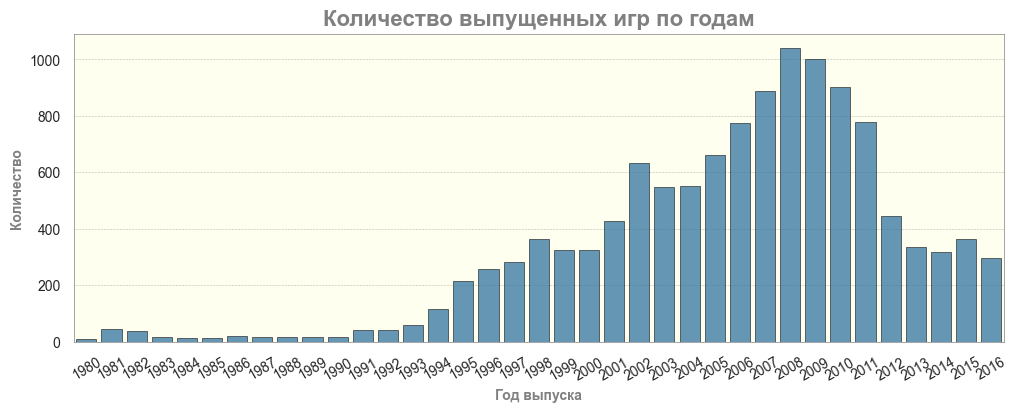

In [406]:
# Рисуем график 
ax = sns.barplot(graph_data,
                 x='year_of_release',
                 y='count', 
                 color=bar_color,
                 alpha=.75,  
                 linewidth=.5, 
                 edgecolor='black')

# Настраиваем параметры
ax.set_title('Количество выпущенных игр по годам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='x', rotation=30)
ax.set_ylabel('Количество', fontdict=fd_10) 
ax.set_xlabel('Год выпуска', fontdict=fd_10) ;

**Вывод:**

1. Игровая индустрия компьютерных игр начала зарождаться в начале **80-х** годов **XX** века. В начале **90-х** годов начался рост количества выпущенных игр.
2. Бурный рост производства игр пришелся на начало **2000-х**, своего пика индустрия достигла в период **2008 - 2009 гг**.
3. После **2010 г**. года наметился спад, здесь видится две причины, разработчики сделали упор на качество, а не на количество в этом немаловажную роль сыграли производители 'железа' кратно нарастившие мощности видеокарт и процессоров. Из этого следует вторая причина - игры стали технически сложней, соответственно увеличились сроки их разработки.

### Платформы с наибольшим продажами на рынке

Проанализируем какие из платформ наиболее успешны с точки зрения продажи контента.

In [407]:
# Соберем данные в сводную таблицу
platform_sales = data.groupby('platform')['total_sales'].\
    agg('sum').sort_values(ascending=False).reset_index()

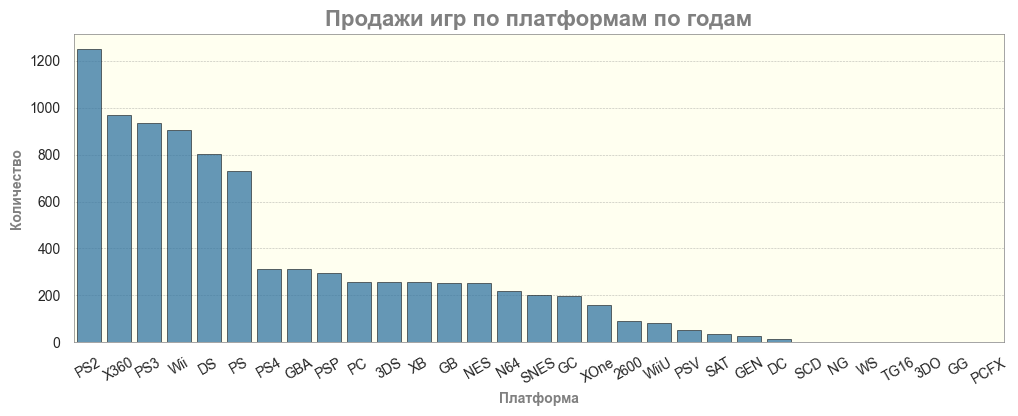

In [408]:
# Рисуем график 
ax = sns.barplot(platform_sales,
                 x='platform',
                 y='total_sales', 
                 color=bar_color,
                 alpha=.75,  
                 linewidth=.5, 
                 edgecolor='black')

# Настраиваем параметры
ax.set_title('Продажи игр по платформам по годам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='x', rotation=30)
ax.set_ylabel('Количество', fontdict=fd_10) 
ax.set_xlabel('Платформа', fontdict=fd_10) ;

Как видим на графике обозначились явные лидеры. Это семейство **PlayStation**, **XBOX** и **Nintendo**. Рассмотрим динамику продаж по годам **6** наиболее успешным платформам.

In [409]:
top_platform = platform_sales.head(6)['platform'].to_list()

In [410]:
# Задаем размеры координатной сетки
h_size = 3
v_size = 2

In [411]:
# Создаем список с координатами плиток 
tile_coordinates = [[h, v] for h in range(h_size) for v in range(v_size)]

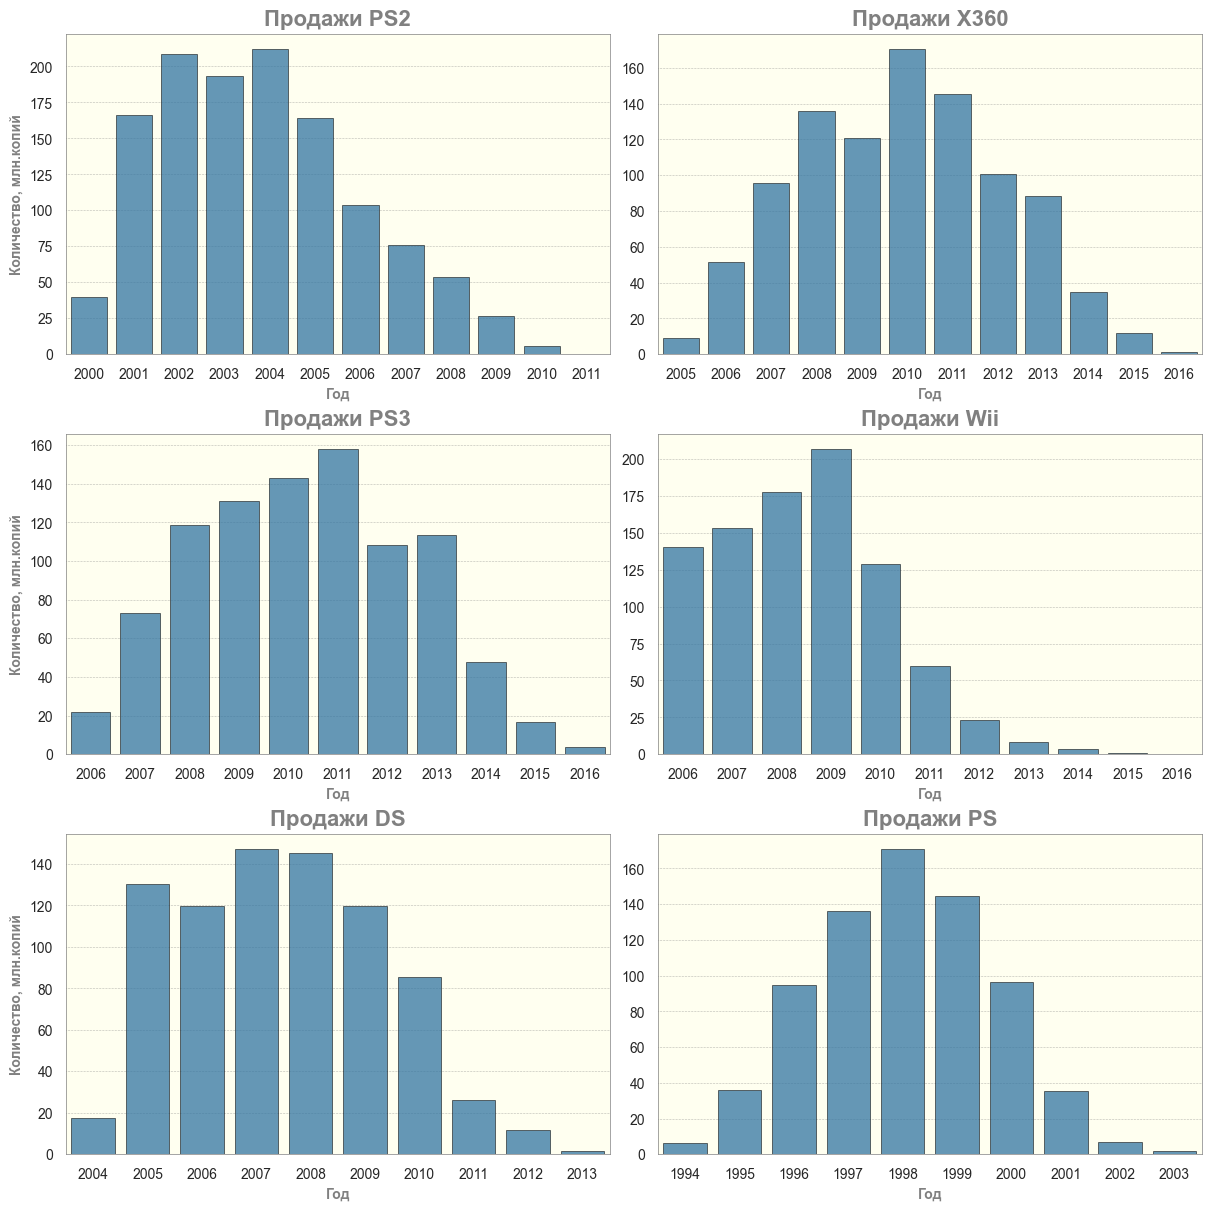

In [412]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height * h_size)
sns.set(rc=graph_set)

# Задаем параметры объекта для построения графиков
fig, axs = plt.subplots(h_size, v_size, constrained_layout=True)

for i, platform in enumerate(top_platform):
     
    #  Создаем датафрейм для отрисовки
    graph_data = data[data['platform'] == platform].\
        groupby('year_of_release')['total_sales'].agg('sum').reset_index()
    
    # Определяем координаты плиток для каждого металла
    pos_x = tile_coordinates[i][0]
    pos_y = tile_coordinates[i][1]

    # Рисуем график 
    ax = sns.barplot(graph_data,
                     x='year_of_release',
                     y='total_sales',
                     ax=axs[pos_x][pos_y],
                     color=bar_color,
                     alpha=.75,  
                     linewidth=.5, 
                     edgecolor='black')

    # Настраиваем параметры
    ax.set_title(f'Продажи {platform}', fontdict=fd_16)
    ax.tick_params(axis='both', labelsize=10)
    # ax.tick_params(axis='x', rotation=30)
    if i % 2 == 0:
        ax.set_ylabel('Количество, млн.копий', fontdict=fd_10)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Год', fontdict=fd_10) ; 

**Выводы:**

1. Платформы вошедшие в топ продаж демострируют либо продолжающийся спад продаж, либо продажи уже прекращены. На текущий момент платформы нового поколения еще не набрали достаточного уровня продаж для попадания в топ.
2. Время жизни платформ у топ представителей **9-11** лет.
3. Наиболее устойчивый уровень продаж продемонстрировала **PlayStation 2** на протяжении **5** лет в диапазоне **150 - 220 млн. копий** в год, до сих пор считается самой успешной платформой на рынке.
4. Наиболее успешной платформой на старте является **Nintendo Wii**, в первый год выпуска обеспечила продажи игр на уровне **140 млн. копий**, возможно это связанно с тем что компания предложила уникальную на тот момент схему управления реагирующую на движение игрока.
5. Наиболее успешным производителем является **Sony**, в топ входят **3** поколения приставок **PlayStation**, **2** приставки от **Nintendo** и **1** от **Microsoft**.

### Время жизни платформ

Создадим вспомогательный датафрейм для расчета времени жизни для каждой из платформ.

In [413]:
# Созадем датафрейм через группировку, преобразовываем в датафрейм
lifetime = data.groupby('platform')[['year_of_release']].\
    agg({'year_of_release':['max', 'min']}).reset_index()

In [414]:
# Переименовываем столбцы для удобства
lifetime.columns = ['platform', 'dead', 'born']

In [415]:
# Добавляем столбец 'lifetime', сортируем по убыванию
lifetime['lifetime'] = lifetime['dead'] - lifetime['born']
lifetime = lifetime.sort_values(by='lifetime', ascending=False)

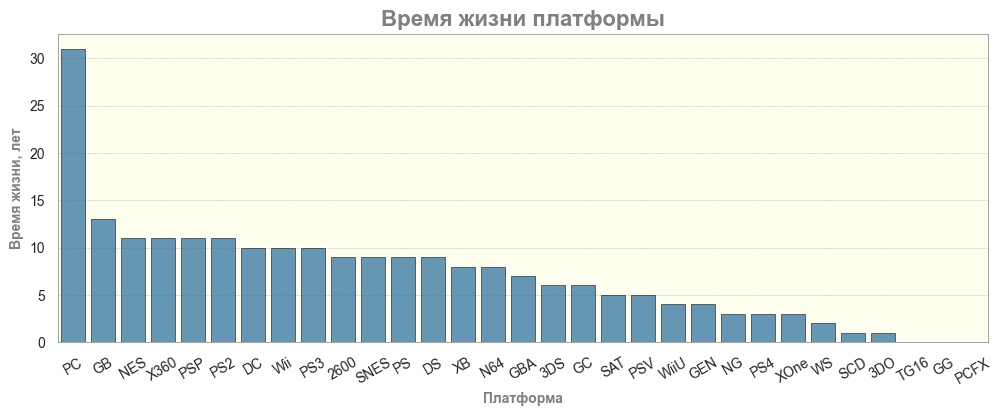

In [416]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height)
sns.set(rc=graph_set)

# Рисуем график 
ax = sns.barplot(lifetime,
                    x='platform',
                    y='lifetime',
                    color=bar_color,
                    alpha=.75,  
                    linewidth=.5, 
                    edgecolor='black')

# Настраиваем параметры
ax.set_title(f'Время жизни платформы', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='x', rotation=30)
ax.set_ylabel('Время жизни, лет', fontdict=fd_10)
ax.set_xlabel('Платформа', fontdict=fd_10) ; 

In [417]:
lifetime.head(5)

,platform,dead,born,lifetime
13,PC,2016,1985,31
5,GB,2001,1988,13
11,NES,1994,1983,11
28,X360,2016,2005,11
19,PSP,2015,2004,11


In [418]:
lifetime['lifetime'].describe()

count                  31.00
mean                    7.10
std                     5.89
min                     0.00
25%                     3.00
50%                     7.00
75%                    10.00
max                    31.00
Name: lifetime, dtype: float64

Отбросим значения для наименее успешных платформ ниже **25** процентиля, посмотрим как изменится среднее и медиана.

In [419]:
lifetime[lifetime['lifetime'] > 3]['lifetime'].describe()

count                  22.00
mean                    9.41
std                     5.44
min                     4.00
25%                     6.25
50%                     9.00
75%                    10.75
max                    31.00
Name: lifetime, dtype: float64

В таком виде данные выглядят более правдоподобно, среднее - **9,4** года и медиана **9** лет и эти показатели наиболее точно харрактеризуют время жизни игровых платформ.

**Выводы:**
1. Среднее время жизни платформы на рынке **9** лет.
2. Наиболее живучей является прородитель всех платформ **PC** - **31** год, основная причина, эта платформа является универсальной, имеет модульную структуру и может бесконечно улучшаться за счет замены отдельных модулей на более современные.
3. На втором месте **Game Boy** портативная игровая приставка, причина долгого нахождения на рынке видится в раннем появлении **1989**, в то время железо равивалось достаточно медленно и данная платформа оставалсь долгое время на плаву, на смену ей пришла портативная платформа следующего поколения **Game Boy Advance**. **GBA** не удалось повторить успех своего предшественника т.к. на рынке появились, более успешные и технические совершенные конкуренты в виде **PSP**.

### Срез данных

Для дальнейшего анализа и подготовки выводов для заказчика предлагается взять срез данных за период **2014 - 2016 гг**. Это позволит увидеть динамику продаж по платформам старого и нового поколения.

In [420]:
lifetime.sort_values(by='dead', ascending=False)

,platform,dead,born,lifetime
13,PC,2016,1985,31
2,3DS,2016,2010,6
30,XOne,2016,2013,3
28,X360,2016,2005,11
26,Wii,2016,2006,10
17,PS3,2016,2006,10
18,PS4,2016,2013,3
27,WiiU,2016,2012,4
20,PSV,2016,2011,5
19,PSP,2015,2004,11


In [421]:
# Проверим количество записей вошедших во вспомогательный срез
actual_data = data[data['year_of_release'] >= 2014]
actual_data.shape[0]

1690

In [422]:
actual_data['platform'].value_counts()

platform
PS4     376
PSV     295
XOne    228
PS3     219
3DS     212
PC      152
X360    111
WiiU     73
PSP      13
Wii      11
Name: count, dtype: int64

Такая выборка данных охватывает продажи как платформ последнего поколения, так и тех платформ, которые уходят с рынка, кроме того позволит оценить растут или падают продажи.

In [423]:
graph_data = actual_data.groupby(['platform', 'year_of_release'], as_index=False).\
    agg(sum=('total_sales', 'sum')).reset_index(drop=True)

In [424]:
# Задаем размеры координатной сетки
h_size = 2
v_size = 5

In [425]:
# Создаем список с координатами плиток 
tile_coordinates = [[h, v] for h in range(h_size) for v in range(v_size)]

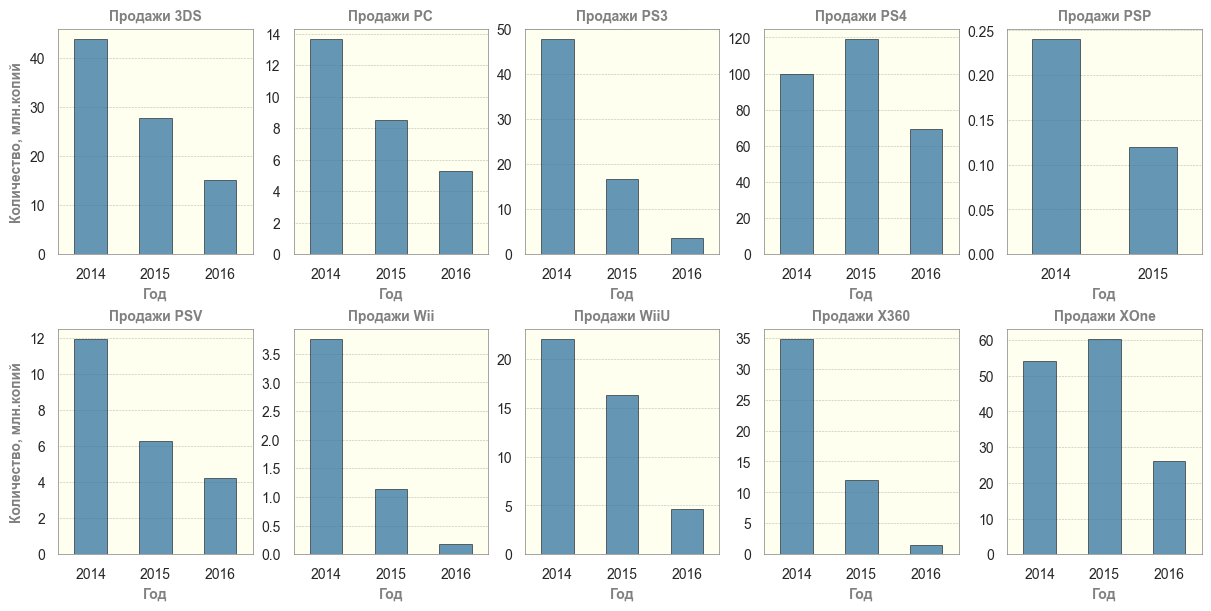

In [426]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height * h_size * 0.75)
sns.set(rc=graph_set)

# Задаем параметры объекта для построения графиков
fig, axs = plt.subplots(h_size, v_size, constrained_layout=True)

platforms = graph_data['platform'].unique()

for i, platform in enumerate(platforms):
    
    # Определяем координаты плиток для каждого металла
    pos_x = tile_coordinates[i][0]
    pos_y = tile_coordinates[i][1]

    # Рисуем график 
    ax = sns.barplot(graph_data[graph_data['platform'] == platform],
                     x='year_of_release',
                     y='sum',
                     ax=axs[pos_x][pos_y],
                     color=bar_color,
                     alpha=.75,  
                     linewidth=.5,
                     width=0.5,
                     edgecolor='black')

    # Настраиваем параметры
    ax.set_title(f'Продажи {platform}', fontdict=fd_10)
    ax.tick_params(axis='both', labelsize=10)
    # ax.tick_params(axis='x', rotation=30)
    if i % 5 == 0:
        ax.set_ylabel('Количество, млн.копий', fontdict=fd_10)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Год', fontdict=fd_10) ; 

Все платформы демонстрируют снижение продаж за последние **3** года. В срез данных вошли как новые разработки так и те, что уже давно на рынке. Предлагается для дальнейшего анализа оставить только те платформы у которых текущий жизненый цикл менее **5** лет к ним добавить 'неустаревающий' **PC**. Обновим выборку.

In [427]:
actual_data = data.query("platform in ('PC', 'PS4', '3DS', 'XOne', 'WiiU', 'PSV') and year_of_release >= 2014")

In [428]:
# Проверим количество записей вошедших в обновленную выборку
actual_data.shape[0]

1336

In [429]:
# Соберем продажи по всем регионам в сводную таблицу
actual_data_pivot = actual_data.pivot_table(index=['platform'], 
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], 
                                            aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index()

In [430]:
actual_data_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   platform     6 non-null      object 
 1   eu_sales     6 non-null      float64
 2   jp_sales     6 non-null      float64
 3   na_sales     6 non-null      float64
 4   other_sales  6 non-null      float64
 5   total_sales  6 non-null      float64
dtypes: float64(5), object(1)
memory usage: 416.0+ bytes


In [431]:
# Добавим в сводную таблицу информацию и жизненом цикле выбранных платформ
actual_data_pivot['lifetime'] = actual_data_pivot['platform'].\
    map(lifetime.set_index('platform')['lifetime'])
actual_data_pivot

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales,lifetime
0,PS4,130.04,15.02,98.61,44.48,288.15,3
1,XOne,46.25,0.32,81.27,12.52,140.36,3
2,3DS,16.12,44.24,22.64,3.68,86.68,6
3,WiiU,13.15,7.31,19.36,3.16,42.98,4
4,PC,18.22,0.00,7.29,1.89,27.40,31
5,PSV,3.53,14.54,2.52,1.81,22.40,5


Наболее перспективными платформами являются **PS4** и **XOne**, они находятся в самом начале своего жизненного цикла и демонстрируют более высокие продажи, чем их старшие конкуренты. У **3DS** также высокие показатели продаж, однако жизненый цикл уже находится на пике.

Рассмотрим продажи по каждой платформе.

In [432]:
actual_data.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.00,0.41,1.19,0.01,0.03,0.09,0.25,11.68
PC,152.00,0.18,0.33,0.01,0.02,0.06,0.21,3.05
PS4,376.00,0.77,1.61,0.01,0.06,0.18,0.69,14.63
PSV,295.00,0.08,0.14,0.01,0.02,0.04,0.09,1.96
WiiU,73.00,0.59,1.16,0.01,0.05,0.19,0.57,7.09
XOne,228.00,0.62,1.05,0.01,0.05,0.20,0.63,7.39


Таблица показывает, что среднее количества проданных копий по каждой игре у **PS4** самая высокая, однако медиана не самая лучшая из всех это говорит о том, что есть успешные проекты по которым у **PS4 очень высокие продажи, что подтверждается максимальным значением, самым высоким из конкурентов.

Наибольшее количество игр у **3DS**, но и на рынке платформа дольше конкурентов и тоже есть успешные проекты, однако среднее и медиана гораздо ниже за счет того, что игр больше.

У основного конкурента **PS4** **Xone** ситуация не очень благоприятная, несмотря на высокий средний показатель, у платформы на **37%** меньше игр, за тот же период жизненого цикла, и на **25%** ниже уровень средних продаж, хотя медианное значение выше всех конкурентов.

Слабые показатели демонстрирует платформа **WiiU** меньше всего игр, хотя уже **5** лет на рынке, однако средние и медианные продажи на уровне конкурентов.

Построим диаграмму распределения для визуализации табличных данных.

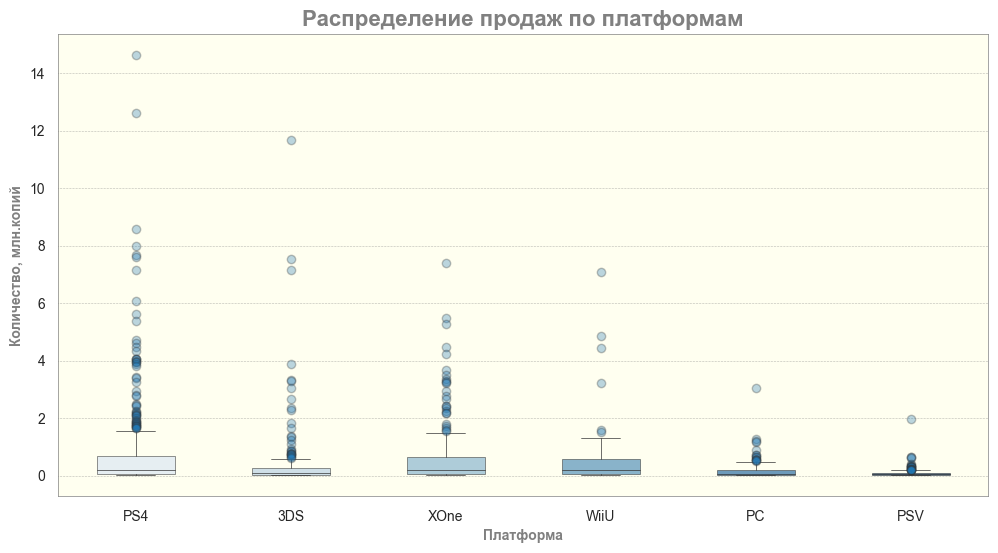

In [433]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height * 1.5)
sns.set(rc=graph_set)

# Рисуем график 
ax = sns.boxplot(actual_data,
                    y='total_sales',
                    x='platform',
                    palette='Blues',
                    boxprops={'alpha':.75},
                    flierprops={'markerfacecolor':'tab:blue',
                                'marker': 'o', 
                                'markersize': 6,
                                'alpha': 0.3}, 
                    linewidth=.5,
                    width=.5)

# Настраиваем параметры
ax.set_title('Распределение продаж по платформам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
# ax.tick_params(axis='x', rotation=30)
ax.set_ylabel('Количество, млн.копий', fontdict=fd_10)
ax.set_xlabel('Платформа', fontdict=fd_10) ; 

Диаграмма подтверждает тезисы о том, что у платформ **3DS** и **PS4** есть ряд успешных проектов, а вот конкуренты пока не могут этим похвастаться.

Выделяется PS4 - 8 'стрельнувших' проектов, при самом длительном времени на рынке.

Отметим платформу PC, у платформы 4 показатель по продажам и более чем в три раза ниже чем у лидера, при этом количество игр на уровне конкурентов. Возможная причина в том, что того приставки менее подвержены пиратству, а для PC можно вполне свободно найти пиратскую версию игры и без особых технических навыков ее установить и пользоваться.

Сделаем диаграмму более читаемой.

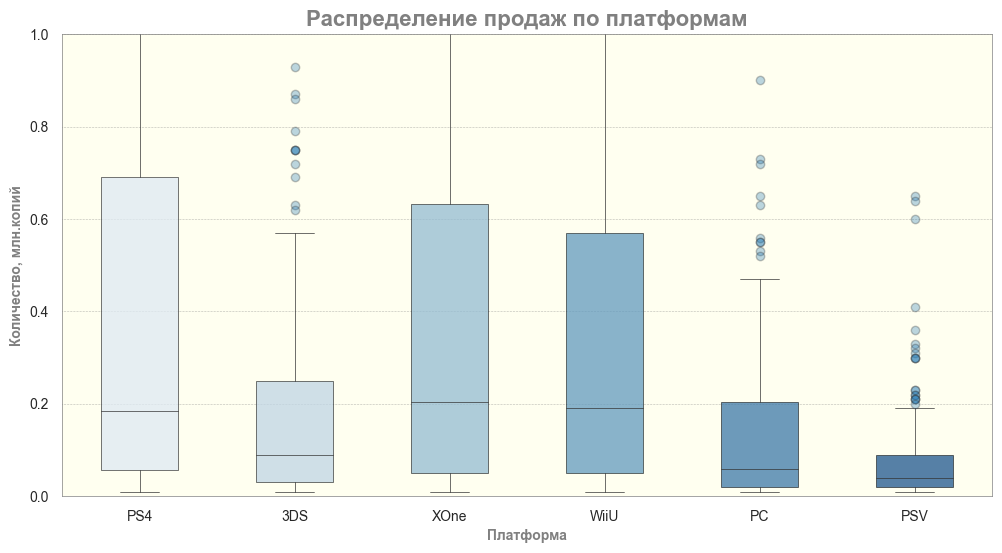

In [434]:
# Рисуем график 
ax = sns.boxplot(actual_data,
                    y='total_sales',
                    x='platform',
                    palette='Blues',
                    boxprops={'alpha':.75, 
                              'edgecolor': 'black'}, 
                    linewidth=.5,
                    width=.5,
                    flierprops = {'markerfacecolor':'tab:blue',
                                  'marker': 'o', 
                                  'markersize': 6,
                                  'alpha': 0.3}
                                  )

# Настраиваем параметры
ax.set_title('Распределение продаж по платформам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)

ax.set_ylabel('Количество, млн.копий', fontdict=fd_10)
ax.set(ylim=(0, 1))
ax.set_xlabel('Платформа', fontdict=fd_10) ; 

В таком виде картина более равномерная, у платформ **PS4**, **WiiU**, **XOne**, есть крепкие середняки, а вот **3DS** заметно проседает. Это говорит о том, что платформа выезжает за счет удачных проектов, а основная масса игр не очень хорошо продается. В этом ключе наиболее выгодно смотрится **PS4** у платформы есть как крепкие середняки так и суперхиты, которые вытаскивают продажи на высокий уровень.

**Выводы:**
1. Наиболее предпочтительной выглядит платформа **PS4**, широкий ассортимент игр, наличие супер-хитов и большой выбор середняков, кроме того платформа находится в начальной фазе жизненного цикла, т.е. разработчики будут продолжать создавать игры для этой платформы.
2. Платформа **3DS** так же имеет неплохие показатели и по количеству игр и по супер-хитам, однако следует внимательно относиться к ассортименту, крепких середняков заметно меньше чем у конкурентов, кроме того платформа уже находиться в самой верхней точке своего жизненного цикла и как показывают графики в предыдущих разделах после пика жизненного цикла продажи начинают заметно снижаться.
3. Платформы **WiiU** и **XOne** демонстрируют чуть более скромные показатели и по количеству игр и по супер-хитам, однако имеют пласт крепких середняков на уровне лидера. Помимо этого эти платформы находятся в начальной стадии жизненного цикла и у них еще есть перспективы, хотя догнать лидера будет непросто, разрыв по количеству игр достаточно большой.
4. **PC** и **PSV** занимают самые низшие позиции. Возможно для **PC** актуально провести отдельное исследование. **PSV** является портативной приставкой, прямые конкурентом 3DS, имеет широкий ассортимент игр, однако заметно проигрывает своему конкуренты по всем показателям продаж.

### Факторы влиящие на продажи

Рассмотрим как влияют отзывы и рейтинги на продажи игр, составим тепловую карту для оценки корреляции.

In [435]:
width, height

(12, 4)

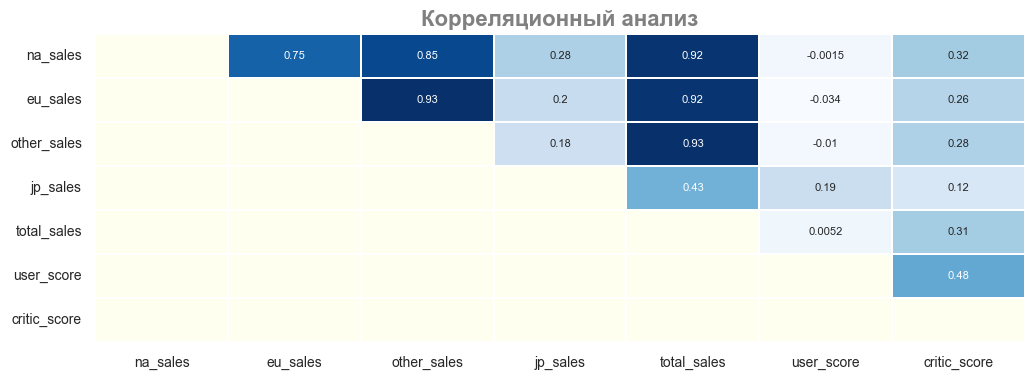

In [436]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height)
sns.set(rc=graph_set)

# Для построения тепловой карты подготовим срез
actual_data_heat = actual_data[['na_sales', 'eu_sales', 'other_sales', 'jp_sales',
                                'total_sales', 'user_score', 'critic_score']]

# Выбираем верхний треугольник матрицы
triangle = np.tril(actual_data_heat.corr())

# Строим тепловую карту корреляционной матрицы
ax = sns.heatmap(actual_data_heat.corr(), 
                 annot=True, 
                 cmap='Blues',
                 mask=triangle, 
                 annot_kws={'fontsize':8},
                 linewidth =.2,
                 cbar=False)

# Настраиваем параметры
ax.set_title('Корреляционный анализ', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.grid(False) ;

Возьмем для анализа и сравним заисимости между отзывами и продажама для отдельных платформ. 

In [437]:
actual_data_corr = actual_data[['platform','total_sales', 'user_score', 'critic_score']]
for platform in actual_data['platform'].unique():
    print(f'Зависимость между объемом продаж и оценками критиков и игроков для платформы {platform}.')
    print()
    print(actual_data_corr[actual_data_corr['platform'] == platform].corr(numeric_only=True))
    print()
    print()

Зависимость между объемом продаж и оценками критиков и игроков для платформы PS4.

                      total_sales           user_score         critic_score
total_sales                  1.00                -0.03                 0.39
user_score                  -0.03                 1.00                 0.55
critic_score                 0.39                 0.55                 1.00


Зависимость между объемом продаж и оценками критиков и игроков для платформы 3DS.

                      total_sales           user_score         critic_score
total_sales                  1.00                 0.24                 0.28
user_score                   0.24                 1.00                 0.59
critic_score                 0.28                 0.59                 1.00


Зависимость между объемом продаж и оценками критиков и игроков для платформы XOne.

                      total_sales           user_score         critic_score
total_sales                  1.00                -0.09        

**Вывод:**
1. Зависимости между оценками критиков, оценками игроков и продажами отсутствует, успешность продаж вероятно обеспечивают маркетинговые и рекламные кампании.
2. Обращает на себя внимание низкий уровень корреляция между оценками игроков и оценками критиков.
3. Выделяется высокое влияние продаж в Северной Америке на общемировые продажи.
4. В разрезе платформ также не выявленно линейной зависимости между оценками критиков и игроков и продажами. Наибольшую зависимость от оценки критиков наблюдается у игр для **PS4 - 0,39**, а от оценки игроков наибольшую зависимость демоснтрирует **WiiU - 0,38**.

### Продажи по жанрам

Рассмотрим продажи по жанрам за актуальный период, составим круговую диаграмму.

In [438]:
graph_data = actual_data.groupby('genre').\
    agg(mean_total_sales=('total_sales','mean')).\
        assign(ratio=lambda x: (x / x.sum() * 100)).\
            sort_values(by='ratio', ascending=False).reset_index()

In [439]:
# Создадим функцию для нанесения подписей данных на бары гистограммы
def add_value_labels(ax, spacing=5, unit='', digit_cap=True):

    # Для каждого столбца устанавливаем подписи данных
    for bar in ax.patches:

        # Получаем координаты подписей данных
        y_value = bar.get_height()
        x_value = bar.get_x() + bar.get_width() / 2

        # Устанавливаем расстояние между баром и подписью данных
        space = spacing

        # Присваиваем подписи данных значение бара, форматируем
        if digit_cap:
            label = f'{round(y_value, 2):,.2f}{unit}'.replace(',', ' ')
        else:
            label = f'{round(y_value, 2):,.0f}{unit}'.replace(',', ' ')

        # Создаем подпись данных
        ax.annotate(label, (x_value, y_value), xytext=(0, space), 
                    textcoords='offset points', ha='center', va='bottom', fontsize=9)

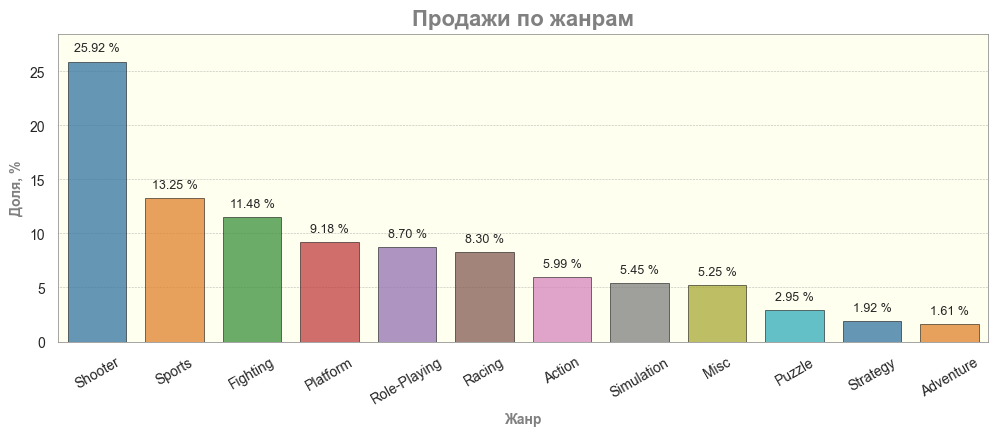

In [440]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height)
sns.set(rc=graph_set)

# Рисуем график 
ax = sns.barplot(x=graph_data['genre'],
                 y=graph_data['ratio'],
                 palette='tab10',
                 alpha=.75,  
                 linewidth=.5,
                 width=0.75, 
                 edgecolor='black')

# Настраиваем параметры
ax.set_title(f'Продажи по жанрам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='x', rotation=30)
add_value_labels(ax, unit=' %')
ax.margins(y=0.1)
ax.set_ylabel('Доля, %', fontdict=fd_10)
ax.set_xlabel('Жанр', fontdict=fd_10) ; 

In [441]:
h_size = 3
v_size = 2

Рассмотрим продажи по жанрам в разрезе платформ.

In [442]:
# Создаем список с координатами плиток 
tile_coordinates = [[h, v] for h in range(h_size) for v in range(v_size)]

In [443]:
# Создаем словарь жанр-цвет
genre_color = {actual_data['genre'].unique()[i]:sns.color_palette('tab10', 12)[i] \
               for i in range(0, len(actual_data['genre'].unique()))}

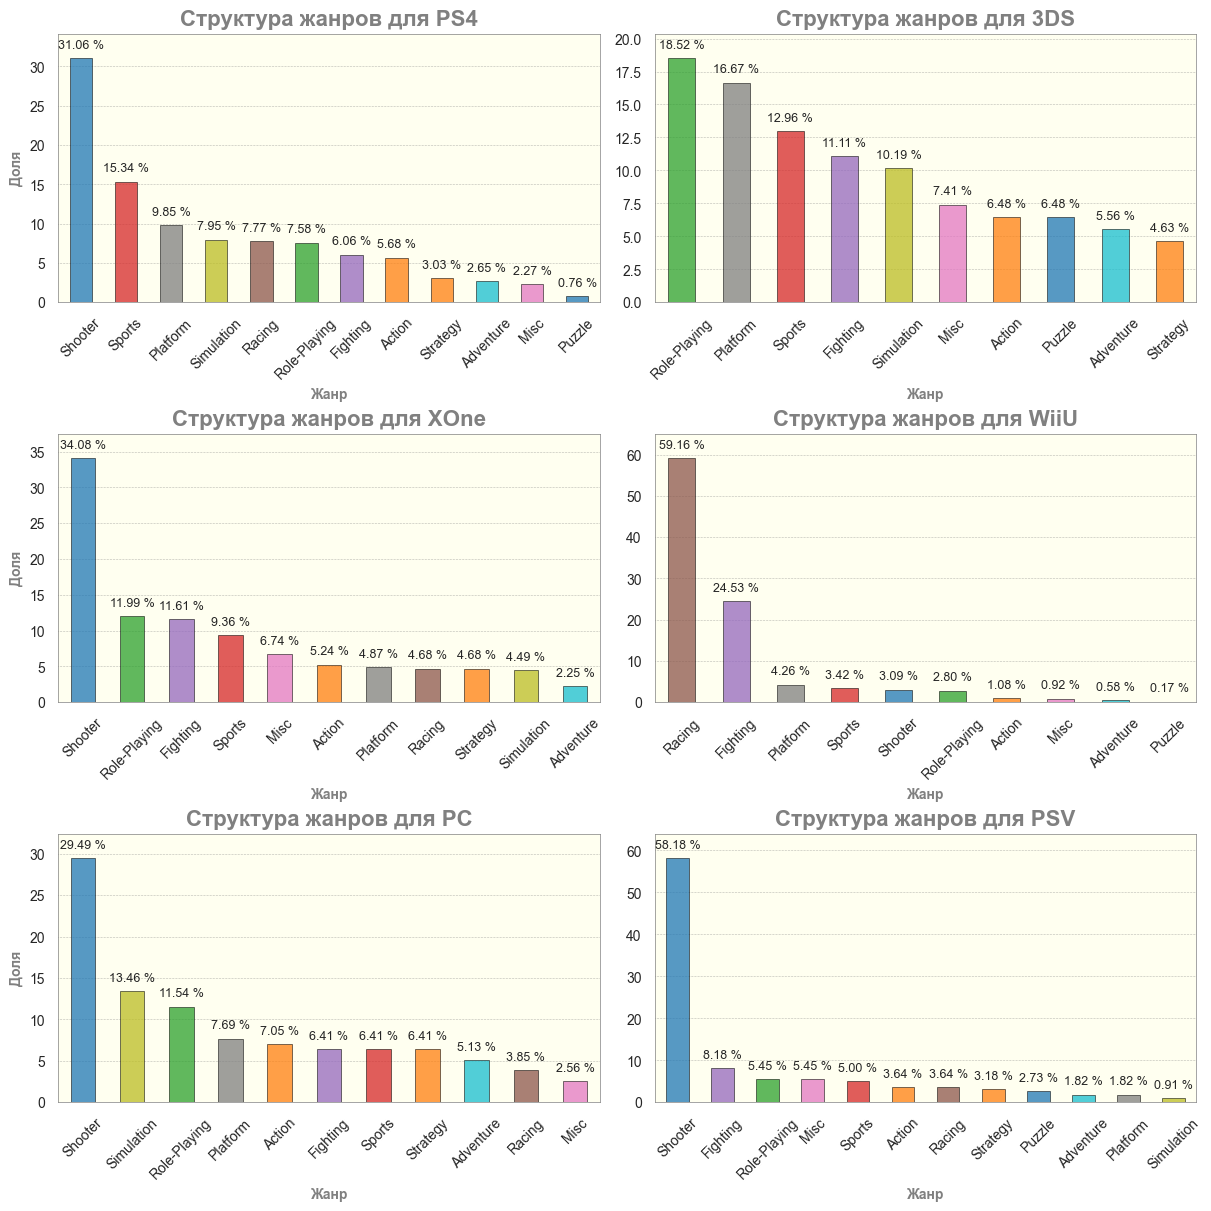

In [444]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height * h_size)
sns.set(rc=graph_set)

# Задаем параметры объекта для построения графиков
fig, axs = plt.subplots(h_size, v_size, constrained_layout=True)

platforms = actual_data['platform'].unique()

for i, platform in enumerate(platforms):
    
    # Определяем координаты плиток для каждого металла
    pos_x = tile_coordinates[i][0]
    pos_y = tile_coordinates[i][1]

    graph_data = actual_data[actual_data['platform'] == platform].groupby('genre').\
        agg(mean_total_sales=('total_sales','median')).\
            assign(ratio=lambda x: (x / x.sum() * 100)).\
                sort_values(by='ratio', ascending=False).reset_index()

    # Рисуем график 
    ax = sns.barplot(x=graph_data['genre'],
                     y=graph_data['ratio'],
                     ax=axs[pos_x][pos_y],
                     alpha=.75,  
                     linewidth=.5,
                     width=0.5,
                     edgecolor='black')

    # Настраиваем параметры
    ax.set_title(f'Структура жанров для {platform}', fontdict=fd_16)
    ax.tick_params(axis='both', labelsize=10)
    ax.tick_params(axis='x', rotation=45)
    if i % 2 == 0:
        ax.set_ylabel('Доля', fontdict=fd_10)
    else:
        ax.set_ylabel('')
    add_value_labels(ax, unit=' %')

    # Присваиваем барам соответствующий цвет
    for i, labels in enumerate(ax.get_xticklabels()):
        ax.patches[i].set_facecolor(genre_color[labels.get_text()]) 

    ax.margins(y=0.1)
    ax.set_xlabel('Жанр', fontdict=fd_10) ; 

**Выводы:**
1. Для всего рынка продаж наиболее предпочтительными являются жанры шутеры, спортивные игры, драки, платформеры, РПГ.
2. По разным платформам продажи по жанрам показывают разные результаты:
    * **PS4** наиболее продаваемые жанры шутер, спорт и платформер;
    * **3DS** наиболее продаваемые жанры  РПГ, платформеры,спорт;
    * **XOne** наиболее продаваемые жанры шутер, РПГ, драки;
    * **WiiU** наиболее продаваемые жанры гонки, драки, платформеры;
    * **PC** наиболее продаваемые жанры шутеры, симуляторы, РПГ;
    * **PSV** наиболее продаваемые жанры шутеры, драки, РПГ;

### Портрет пользователя

Составим портрет пользователя для каждого региона продаж, будем использовать вспомогательный датафрейм `actual_data`.

In [445]:
h_size = 4
v_size = 2

In [446]:
# Создаем список с координатами плиток 
tile_coordinates = [[h, v] for h in range(h_size) for v in range(v_size)]

In [447]:
# Создаем список колонок для построения графиков
columns = [[x, y] for x in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'] \
           for y in ['platform', 'genre']]

regions = ['Северная Америка', 'Европа', 'Япония', 'Прочие']

In [448]:
# Создаем словарь жанр-цвет
platform_color = {actual_data['platform'].unique()[i]:sns.color_palette('tab10')[i] \
               for i in range(0, len(actual_data['platform'].unique()))}

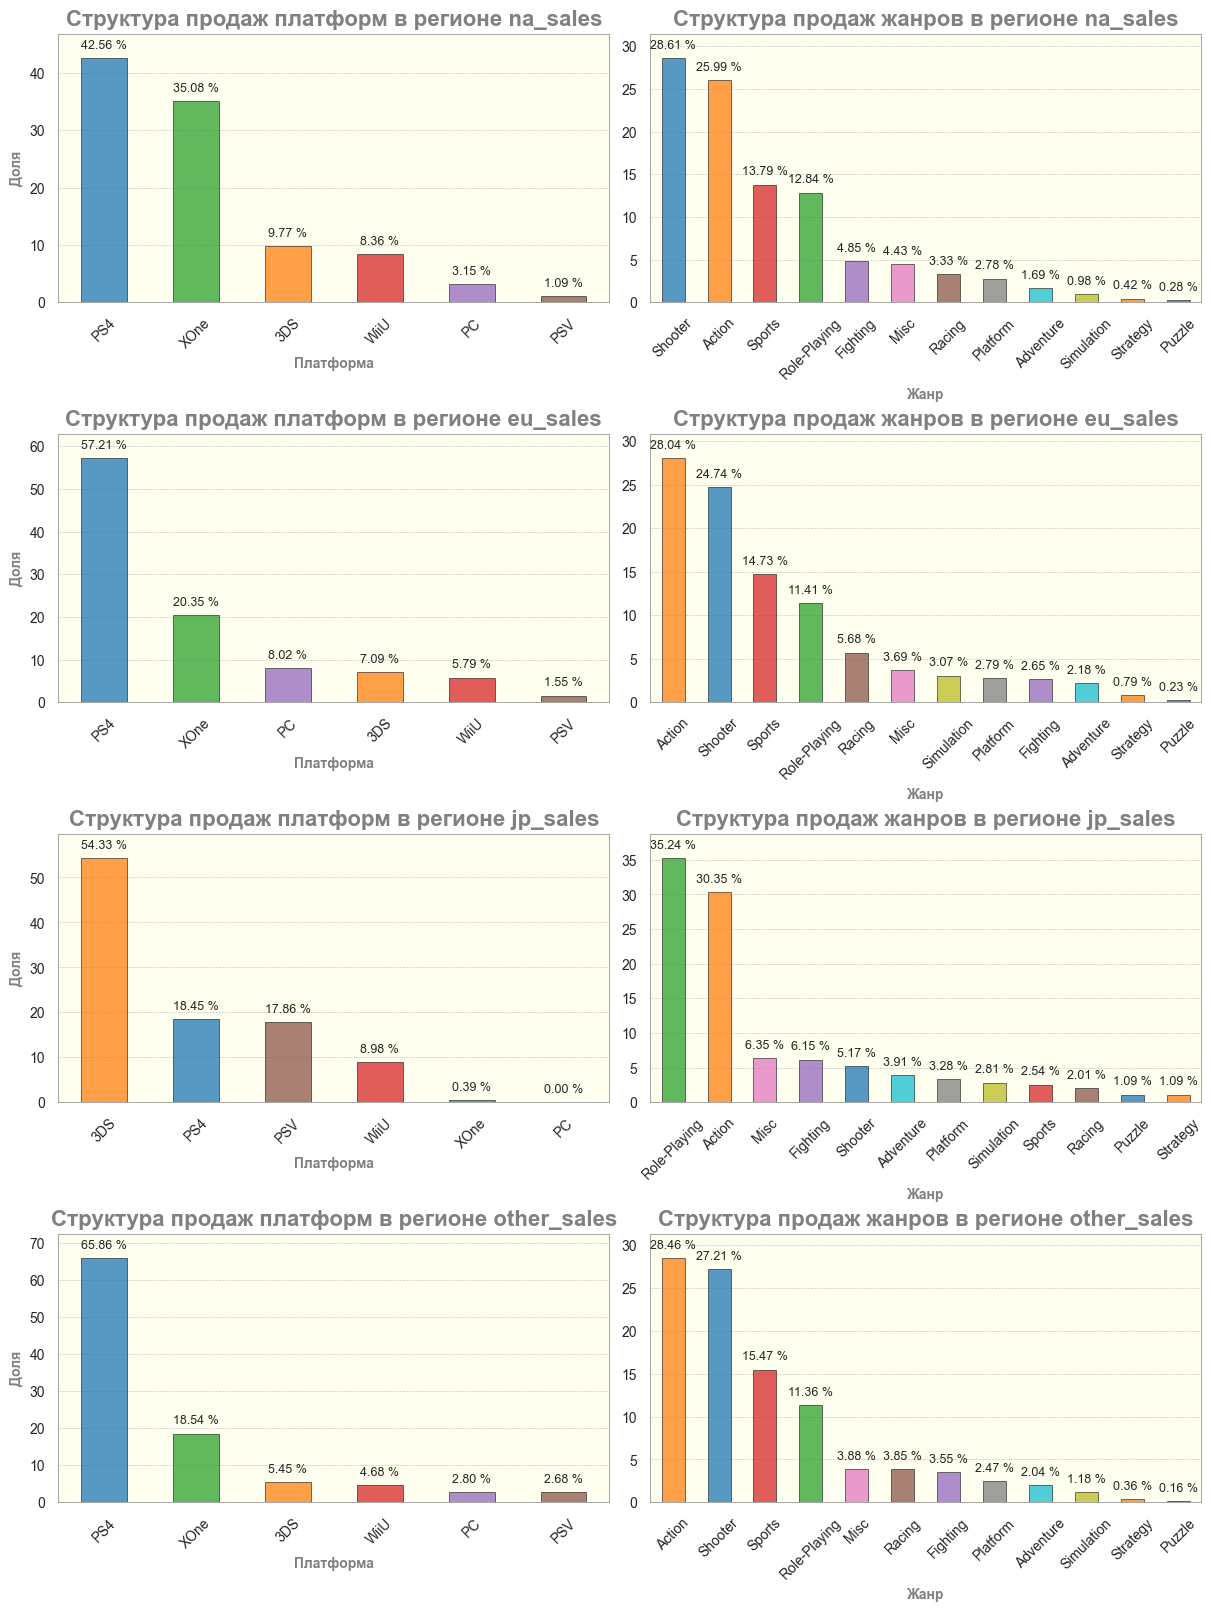

In [449]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height * h_size)
sns.set(rc=graph_set)

# Задаем параметры объекта для построения графиков
fig, axs = plt.subplots(h_size, v_size, constrained_layout=True)

for i, col in enumerate(columns):
    
    # Определяем координаты плиток
    pos_x = tile_coordinates[i][0]
    pos_y = tile_coordinates[i][1]

    graph_data = actual_data.groupby(col[1]).\
        agg(region_sales=(col[0], 'sum')).\
            assign(ratio=lambda x: (x / x.sum() * 100)).\
                sort_values(by='ratio', ascending=False).reset_index()

    # Рисуем график 
    ax = sns.barplot(x=graph_data[col[1]],
                     y=graph_data['ratio'],
                     ax=axs[pos_x][pos_y],
                     alpha=.75,  
                     linewidth=.5,
                     width=0.5,
                     edgecolor='black')

    # Настраиваем параметры
    
    ax.tick_params(axis='both', labelsize=10)
    ax.tick_params(axis='x', rotation=45)
    if i % 2 == 0:
        ax.set_title(f'Структура продаж платформ в регионе {col[0]}', fontdict=fd_16)
        ax.set_ylabel('Доля', fontdict=fd_10)
        ax.set_xlabel('Платформа', fontdict=fd_10)

        # Присваиваем барам соответствующий цвет
        for i, labels in enumerate(ax.get_xticklabels()):
            ax.patches[i].set_facecolor(platform_color[labels.get_text()]) 
    else:
        ax.set_title(f'Структура продаж жанров в регионе {col[0]}', fontdict=fd_16)
        ax.set_ylabel('')
        ax.set_xlabel('Жанр', fontdict=fd_10)

        # Присваиваем барам соответствующий цвет
        for i, labels in enumerate(ax.get_xticklabels()):
            ax.patches[i].set_facecolor(genre_color[labels.get_text()]) 

    add_value_labels(ax, unit=' %')

    ax.margins(y=0.1); 

* В **Северной Америке** предпочитают играть в  шутеры **29%**, экшен **26%** и спорт **14%** на платформах **PS4** **43%**, **XOne** **35%**, **3DS 10%**.
* В **Европе** предпочитают жанры экшен **28%**, шутер **25%**, спорт **15%** на платформах **PS4 57%**, **XOne 15%**, **PC 8%**.
* В **Японии** играют в РПГ **35%**, и экшен **30%**, на платформе **3DS 54%**, **PS4 18%**, **PSV 18%**, **WiiU 9%**, **XOne** в регионе вообще не представлен.
* Прочие регионы играют в экшен **28%**, шутер **27%**, спорт **15%**, РПГ **11%** на платформах **PS4 66%**, **XOne 19%**, **3DS 5%**, **WiiU 5%**.

**Выводы:**
1. Во всех исследуемых регионах за исключением **Японии** среди платформ явное преимущество **PS4**. Японцы предпочитают **3DS**.
2. Наиболее востребованым жанром является шутер и экшен за исключением **Японии**, там игроки больше предпочитают РПГ и экшен.
3. В Японии нет рынка игр для **XOne** и **PC**, можно отметить что японский рынок кардинально отличается от прочих представленных и по распределению платформ и по жанрам.

### Рейтинг продаж для платформ, жанров и регионов

Составим рейтинги для платформ и жанров

In [481]:
# Составляем рейтинг для платформ
top = actual_data.groupby('platform', as_index=False).agg(sum=('total_sales','sum')).\
    sort_values(by='sum', ascending=False).head(5).reset_index(drop=True)
top

,platform,sum
0,PS4,288.15
1,XOne,140.36
2,3DS,86.68
3,WiiU,42.98
4,PC,27.40


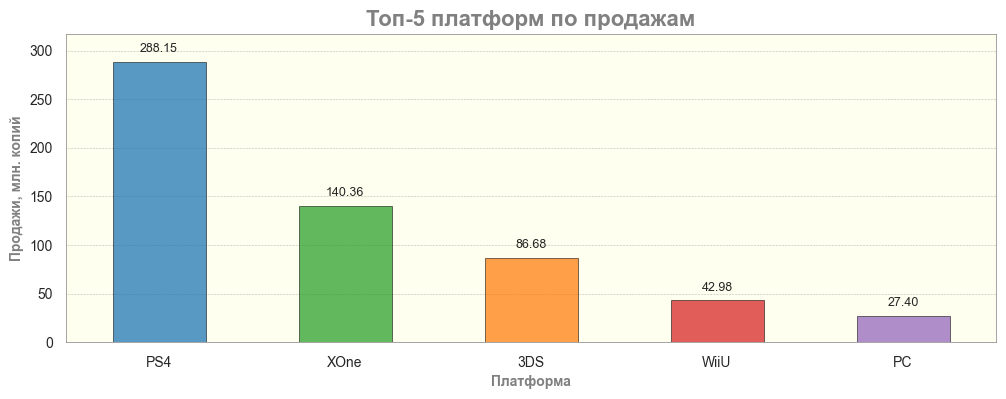

In [487]:
# Задаем параметры объекта для построения графиков
graph_set['figure.figsize'] = (width, height)
sns.set(rc=graph_set)

# Рисуем график 
ax = sns.barplot(x=top['platform'],
                    y=top['sum'],
                    alpha=.75,  
                    linewidth=.5,
                    width=0.5,
                    edgecolor='black')

# Настраиваем параметры
ax.set_title(f'Топ-5 платформ по продажам', fontdict=fd_16)
ax.tick_params(axis='both', labelsize=10)
ax.set_ylabel('Продажи, млн. копий', fontdict=fd_10)

add_value_labels(ax)

# Присваиваем барам соответствующий цвет
for i, labels in enumerate(ax.get_xticklabels()):
    ax.patches[i].set_facecolor(platform_color[labels.get_text()]) 

ax.margins(y=0.1)
ax.set_xlabel('Платформа', fontdict=fd_10) ; 

<Axes: title={'center': 'Распределение продаж по платформам ТОП-5'}, ylabel='total_sales'>

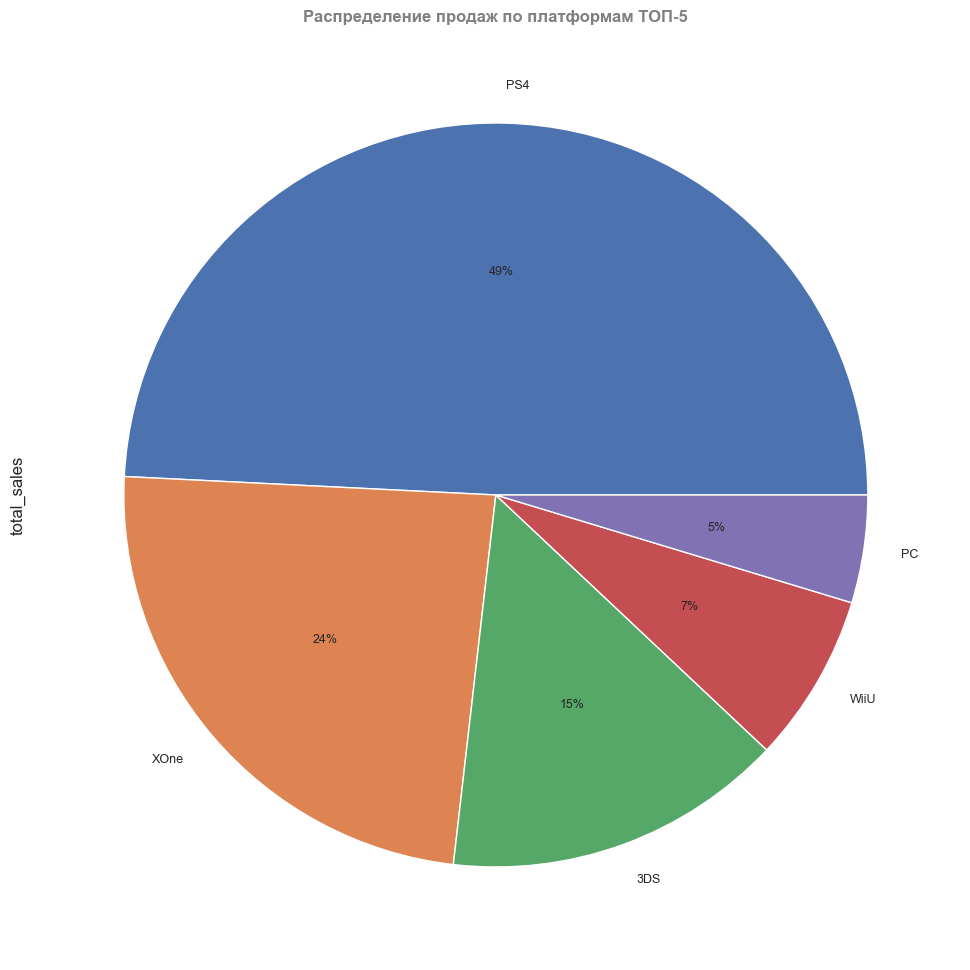

In [451]:
actual_data.groupby('platform')['total_sales'].agg('sum').sort_values(ascending=False).head(5).\
plot(kind='pie', y='total_sales', autopct='%1.0f%%', title='Распределение продаж по платформам ТОП-5', fontsize=9)

In [452]:
# Составляем рейтинг для жанров
actual_data.groupby('genre')['total_sales'].agg('sum').sort_values(ascending=False).head(5)

genre
Action                       167.89
Shooter                      145.11
Role-Playing                  92.05
Sports                        77.96
Misc                          26.43
Name: total_sales, dtype: float64

<Axes: title={'center': 'Распределение продаж по жанрам ТОП-5'}, ylabel='total_sales'>

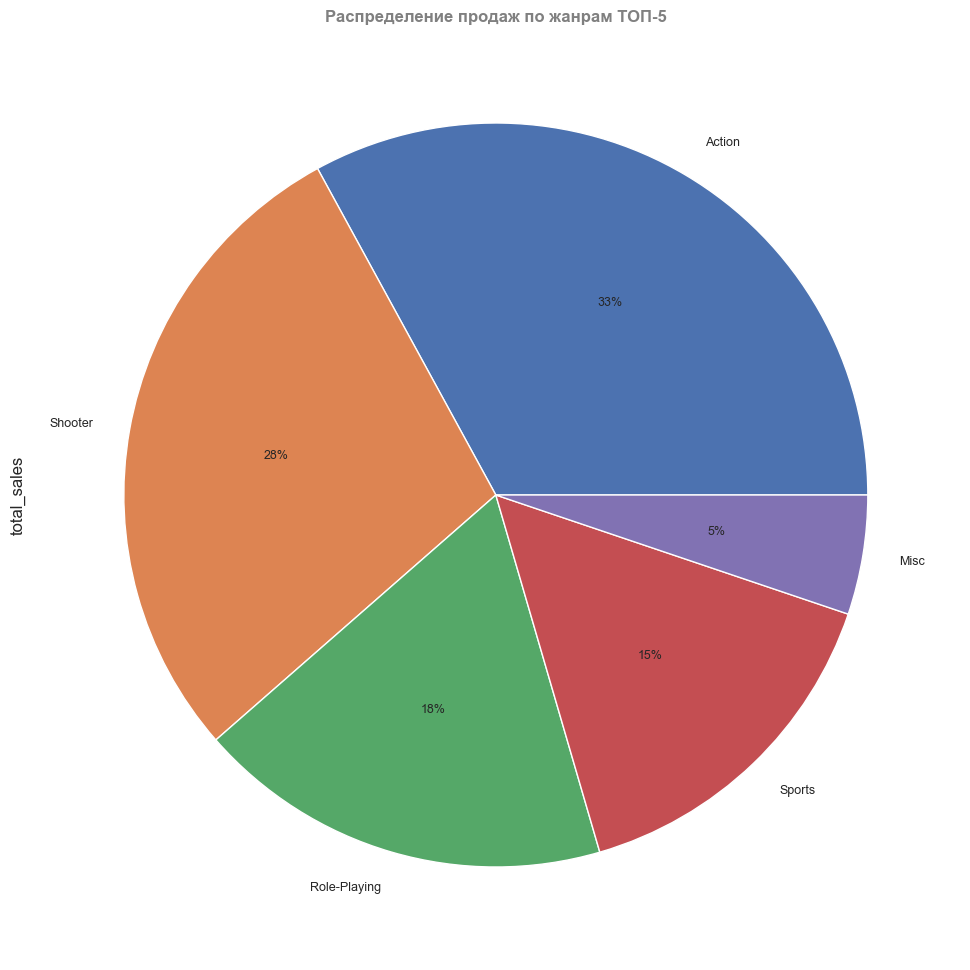

In [453]:
actual_data.groupby('genre')['total_sales'].agg('sum').sort_values(ascending=False).head(5).\
plot(kind='pie', y='total_sales', autopct='%1.0f%%', title='Распределение продаж по жанрам ТОП-5', fontsize=9)

In [454]:
# Составим рейтинг для регионов продаж
region_sales = {'region': ['Северная Америка',
                           'Европа',
                           'Япония',
                           'Прочие',],
                'sales':[actual_data['na_sales'].sum(),
                         actual_data['eu_sales'].sum(),
                         actual_data['jp_sales'].sum(),
                         actual_data['other_sales'].sum(),],
                }

pd.DataFrame(region_sales).groupby('region')['sales'].agg('sum').sort_values(ascending=False)

region
Северная Америка                 231.69
Европа                           227.31
Япония                            81.43
Прочие                            67.54
Name: sales, dtype: float64

<Axes: title={'center': 'Продажи по регионам'}, ylabel='sales'>

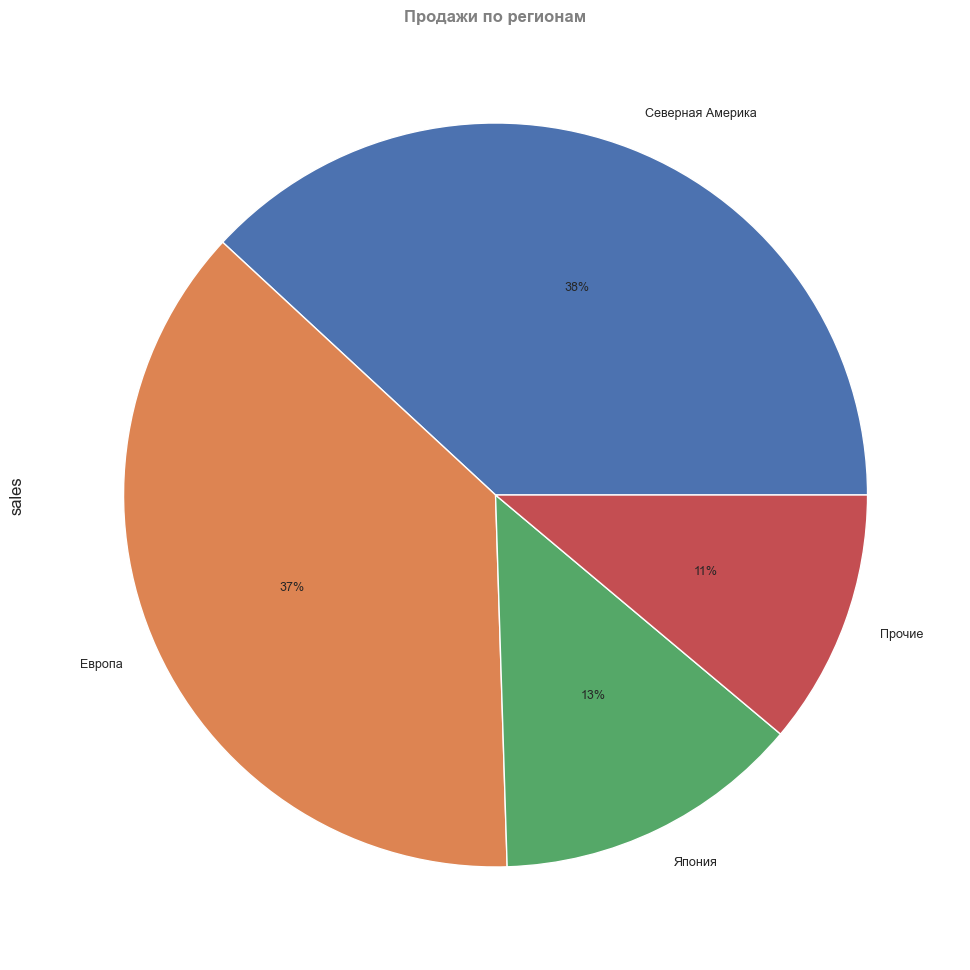

In [455]:
pd.DataFrame(region_sales).groupby('region')['sales'].agg('sum').sort_values(ascending=False).\
plot(kind='pie', y='sales', autopct='%1.0f%%', title='Продажи по регионам', fontsize=9)

**Выводы:**
1. Топ-5 по платформам возглавляет **PS4**.
2. Топ-5 по жанрам возглавляют игры жанра экшен.
3. Самые крупные рынки для компьютерных игр в **Северной Америке** и в **Европе**.

### Влияние рейтинга ESRB на продажи

Построим диаграммы для каждого региона

<Axes: title={'center': 'Прочие регионы'}, xlabel='rating'>

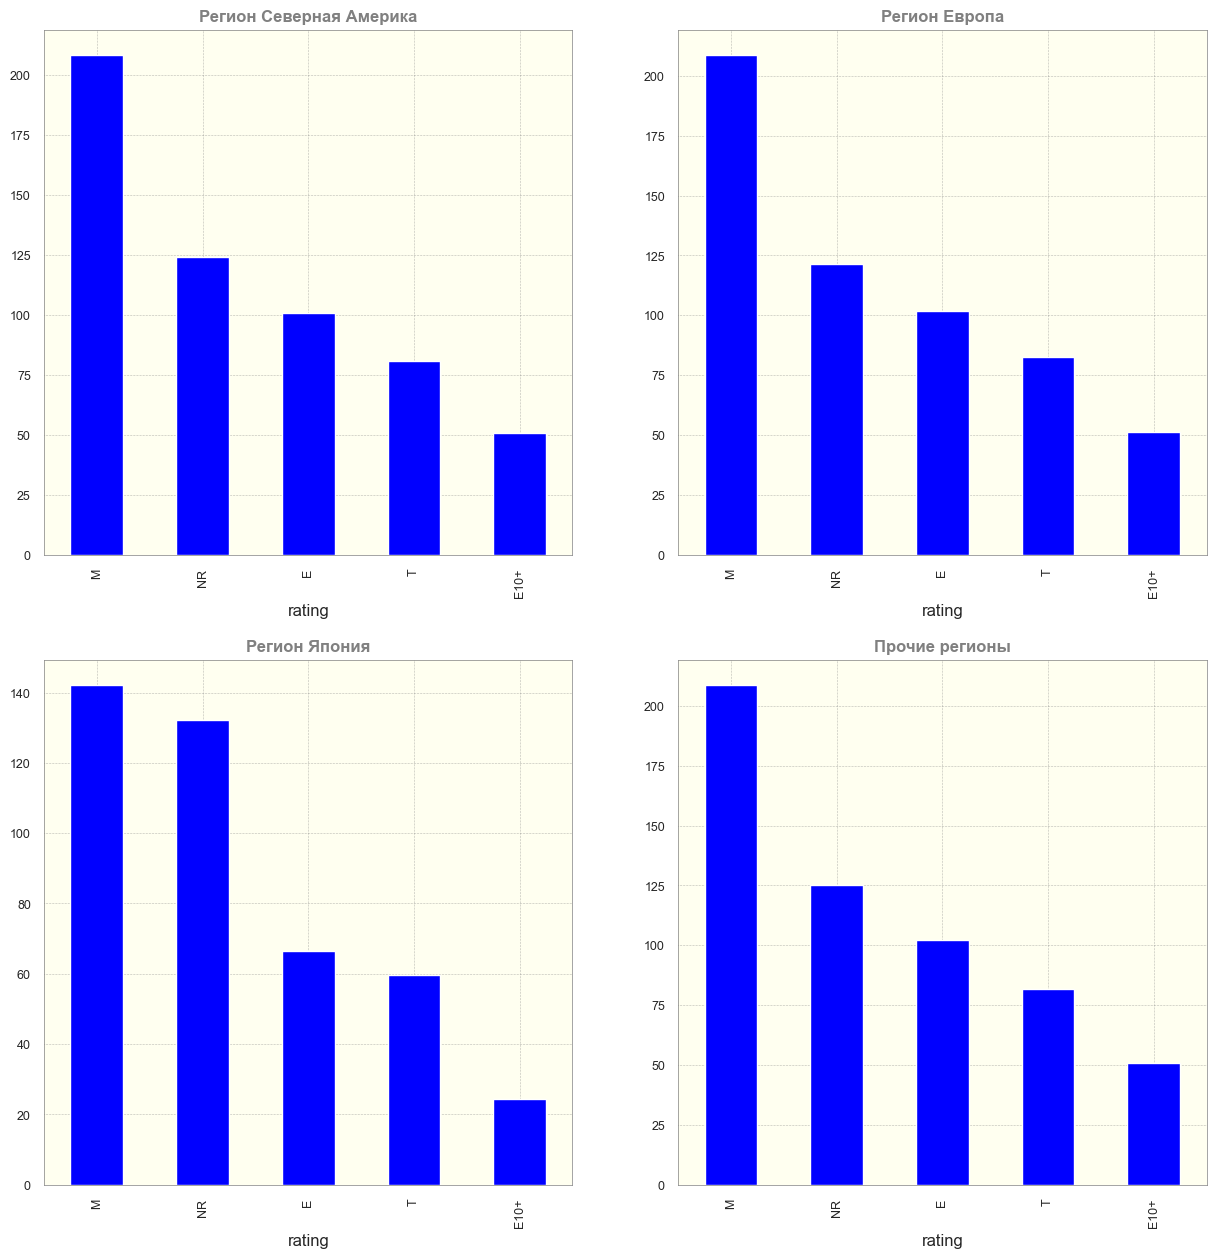

In [456]:
# Настраиваем отображение
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Составляем диаграммы для каждого из представленных регионов
actual_data[actual_data['na_sales'] > 0].groupby('rating')['total_sales'].agg('sum').\
    sort_values(ascending=False).\
    plot(kind='bar', color='blue', ax=axs[0, 0], title='Регион Северная Америка', fontsize=9)

actual_data[actual_data['eu_sales'] > 0].groupby('rating')['total_sales'].agg('sum').\
    sort_values(ascending=False).\
    plot(kind='bar', color='blue', ax=axs[0, 1], title='Регион Европа', fontsize=9)

actual_data[actual_data['jp_sales'] > 0].groupby('rating')['total_sales'].agg('sum').\
    sort_values(ascending=False).\
    plot(kind='bar', color='blue', ax=axs[1, 0], title='Регион Япония', fontsize=9)

actual_data[actual_data['other_sales'] > 0].groupby('rating')['total_sales'].agg('sum').\
    sort_values(ascending=False).\
    plot(kind='bar', color='blue', ax=axs[1, 1], title='Прочие регионы', fontsize=9)

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Здесь мы потеряли игры без рейтинга (в самом начале тетрадки у меня был комментарий про то, что мы не должны забыть обработать NaN в 'rating'). Если выполнить (**псевдокод!**): **df_actual['rating'].value_counts(dropna=False)**, то получим, что кроме игр с явными рейтингами (которые ты ниже и анализируешь) есть ещё около тысячи игр без рейтинга. Но продажи именно таких игр могут указать на ключевое различие в регионах. 
Исправь пожалуйста эту ошибку и посмотри - не поменялись ли твои выводы.</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Да, теперь игры без рейтинга из нашего анализа не выпадают, отлично!
</div>


Справочно:
* **М** - контент для детей от 17 лет и старше
* **T** - контент для детей от 13 лет и старше
* **Е10+** - контент для детей от 10 лет и старше
* **E** - контент для всех возрастов
* **RP** - рейтинг для контента еще не присвоен

**Выводы:**
1. Наибольшие продажи по всем регионам наблюдаются для игр с рейтингом М, причины такого распределения в предпочтениях игроков, как мы выяснили ранее, наиболее востребованные жанры это шутеры, где без сцен насилия, убийств не обойтись. <div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>На 3-м месте продажи игр без рейтинга. Как уже отмечалось выше мы заменили отсутствующие данные маркером NR. Нам достоверно не известна причина отсутствия данных, возможно рейтинг есть, но он не попал в выгрузку или изначально отсутствовал в базе данных.</font>
</div>
2. Выделяется Япония где совсем немного отставая от лидера продажи игр категории Е - для всех возрастов. Возможные причины кроются в особенностях японской культуры.<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>На японском рынке выделяются продажи игр без рейтинга, объяснить то можно тем, что много игр выпускается только для рынка Японии, соответственно нет необходимости получать американский ESRB рейтинг.</font>
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>

(После исправления красного комментария выше) А чем на твой взгляд можно объяснить то, что в Японии лидерами продаж (в количестве копий) являются игры без рейтинга ESRB?</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Да, верно! Рейтинг ESRB - это американский рейтинг, а в Японии есть своё рейтинговое агентство (CERO). Получается, что Япония страна со своим менталитетом. И твой анализ показывает, что Японцы в игры-то играют не такие, как весь прочий мир и жанры игр там популярны совсем другие, нежели в остальном мире, да и на рейтинги (не своего агентства) не очень-то внимание обращают.
</div>


## Проверка гипотез

Согласно техническому заданию заказчика требуется проверить две гипотезы:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Средние пользовательские рейтинги жанров Action и Sports разные

### Проверка гипотезы №1. "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Для проверки гипотезы "средние пользовательские рейтинги платформ Xbox One и PC одинаковые" сформулируем их следующим образом
* H0: средние рейтинги по платформам одинаковые
* H1: средние рейтинги по платформам разные
Для проверки гипотез будем рассматривать вспогательный датафрейм 'actual_data' как генеральную совокупность. т.е. будут сравниваться средние двух генеральных совокупностей оценок по платформе PC и XOne. разного размера.

In [457]:
# создадим вспомогатлеьные дататфреймы для каждой платформы отбросим строки где нет отзывов
actual_data_pc = actual_data[(actual_data['platform'] == 'PC') & (~actual_data['user_score'].isna())]
actual_data_xone = actual_data[(actual_data['platform'] == 'XOne') & (~actual_data['user_score'].isna())]

# Определим параметр уровень статистической значимости
alpha = .05

# Рассчитаем значение p-value
result = st.ttest_ind(actual_data_xone['user_score'], actual_data_pc['user_score'])

In [458]:
# Если pvalue ниже уровня статистической значимости не отвергаем нулевую гипотезу
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.041367339891362195
Отвергаем нулевую гипотезу


**Вывод:**
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>1. На основании проведенного теста, нет оснований утверждать, что пользовательские оценки для платформ PC, XOne равны.</font>
</div>
1. Гипотеза о том, что средние пользовательские оценки для платформ PC XOne равны не подтвердилась

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Нельзя сделать вывод, что тест "подтвердил" одну из гипотез (в статистике гипотезы подтвердить невозможно) или "подтвердил" равенство/неравенство (можно говорить только о статистически (не)значимом различии). Например так: «У нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются».

И ещё на эту же тему: никакие экспериментально полученные данные никогда не подтвердят какую-либо гипотезу. Это наше фундаментальное ограничение. Данные могут лишь не противоречить ей или, наоборот, показывать крайне маловероятные результаты (при условии, что гипотеза верна). Но и в том, и в другом случае нет оснований утверждать, что выдвинутая гипотеза доказана. Допустим, данные гипотезе не противоречат, тогда мы её не отвергаем. Если же мы приходим к выводу, что получить такие данные в рамках этой гипотезы вряд ли возможно, у нас появляется основание отбросить эту гипотезу. Статья на эту тему: https://allatambov.github.io/psms/pdf/hypo-test.pdf
</div>


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>Комментарий принят, выводы откорректированны</font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

+
</div>


### Проверка Гипотезы №2. "Средние пользовательские рейтинги жанров Action и Sports разные".

Для проверки гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные" сформулируем их следующим образом
* H0: средние рейтинги по жанрам одинаковые
* H1: средние рейтинги по жанрам разные


Для проверки гипотез будем рассматривать вспогательный датафрейм 'actual_data' как генеральную совокупность. т.е. будут сравниваться средние двух генеральных совокупностей оценок по платформе PC и XOne. разного размера.

In [459]:
# создадим вспомогатлеьные дататфреймы для каждого жанра отбросим строки где нет отзывов
actual_data_action = actual_data[(actual_data['genre'] == 'Action') & (~actual_data['user_score'].isna())]
actual_data_sports = actual_data[(actual_data['genre'] == 'Sports') & (~actual_data['user_score'].isna())]

# Определим параметр уровень статистической значимости
alpha = .05

# Рассчитаем значение p-value
result = st.ttest_ind(actual_data_action['user_score'], actual_data_sports['user_score'])

In [460]:
# Если pvalue ниже уровня статистической значимости не отвергаем нулевую гипотезу
print('p-значение:', result.pvalue)
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.488535560020801e-13
Отвергаем нулевую гипотезу


**Выводы:**
<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>1. На основании проведенного теста, можно утверждать, что гипотеза о том, что пользовательские оценки для жанров Action и Sport равны. статистически не значима.</font>
</div>
1. Гипотеза о том, что средине пользовательские оценки для жанров Action и Sports равны не подтвердилась

## **Выводы:**
1. В рамках проекта по исследованию критериев успешности компьютерных игр выполнена предварительная обработка данных и анализ предоставленного датасета
2. Выявлены наиболее успешные с точки зрения продаж игр платформы это PS4, 3DS, XOne, однако следует учитывать то, что 3DS находится на пике жизненного цикла и в ближайшие 2-3 года может появиться платформа следующего поколения. Явным лидером выступает PS4 по широте ассортимента и наличию игр хитов.
3. Определены портреты пользователей для разных регионов. Собирательный образ это пользователь PS4 предпочитающий жанр экшен за исключением Японии, там пользователь предпочитает играть в РПГ на 3DS. Более подробно можно ознакомиться с выводами в п 3.8.
4. Опеределено, что отзывы критиков и игроков не оказывают влияния на успешность продаж игр.
5. Определен средний жизненный цикл платформ - 9 лет.
6. Определен наиболее предпочтительный игровой жанр - экшен.
7. Определены наиболее перспективные рынки продаж это Северная Америка и Европа 38% и 36% рынка сответственно.
8. Определено, что наиболее востребованы на рынке игры с рейтингом М, для Японии М и Е
9. Проверена и подтверждена гипотеза о том, что средние оценки пользователей для игр на платформах PC и XOne равны.
10. Проверена и не подтверждена гиртеза о том, что средние оценки пользователей для жанров Action и Sports равны.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><b>Выводы:</b>

        
1. В рамках проекта по исследованию критериев успешности компьютерных игр выполнена предварительная обработка данных и анализ предоставленного датасета.
2. В настоящий момент после активного роста количества выпущенных игр в период 2000-2010 года рынок стабилизировался на уровне примерно 300 выпущеных игр в год со слабой тенденцией к снижениию.
3. Лидерами по продажам игр являются Северная Америка и Европа, суммарно 75% рынка.
4. За период 2011-2016гг все основные платформы PS4, 3DS, XOne, WiiU, показали снижение продаж.
5. Наиболее предпочтительной платформой для регионов Северная Америка, Европа и прочие является PS4, доли рынка 43-66%, на втором месте XOne c долями 19-35%, в Японии лидер 3DS с долей рынка 54%. Для японского рынка харрактерно использование портативных консолей, общая доля таких устройств составляет 72%. Рекомендуется формировать ассортиментную матрицу региональных магазинов исходя из указанных долей рынка, для платформы 3DS объем закупаемых игр снизить, приставка находится на пике жизненного цикла и в ближайшие 2-3 года может появиться консоль нового поколения. 
6. Наиболее предпочтительными жанрами для игроков Северной Америки, Европы и прочих регионов являются экшен и шутер доли 26-28% по регионам, и шутер доля по регионам 25-29%. На японском рынке предпочтения отдают РПГ 35% и экшен 30%. Рекомендеется формировать ассортиментую матрицу региональных магазинов исходя из указанных предпочтений пользователей.
7. В результат анализа определено, что отсутствует линейная зависимость между оценками пользователей и критиков и объемами продаж игр ни в целом, ни по отдельным платформам. Рекомендуется при формировании ассортимента магазинов учитывать этот фактор. 
6. Проверено влияние рейтинга ESRB на продажи игр, выявленно, что больше всего продается игр с рейтингом М, вторую строчку занимают продажи игр без рейтинга, однако достоверно неизвестно, действительно ли отсутствует рейтинг или о нем нет информации. Отдельно выделяется японский рынок на нем доминируют продажи игр без рейтинга, возможно по той причине, что много игр выпускается адресно для японского рынка и они не требуют наличия рейтинга ESRB, на второй и третьей строчки игры с рейтингом М и Е. Большое количество продаж игр с рейтингом М коррелирует с жанровыми предпочтениями игроков. 
7. Проверены две гипотезы: О равенстве средних оценок для платформ PC XOne и О равенстве средних оценок для жанров Action и Sport в результате проверки определено, что обе гипотезы статистически не значимы.</font>
</div>

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

Давай представим вполне себе реалистичный сценарий: после выполнения анализа ты готовишь презентацию для топ-менеджмента компании и получаешь приглашение на совет директоров для рассказа и представления своих выводов. Ты ровно эти выводы с собой понесешь? Достаточно ли они детальны, описывают ли они все аспекты (задачи из брифа), которые мы должны были обнаружить, интерпретировать и описать?

И самое главное - нам, нашей компании "Стримчик"-то что делать? Мы не разработчики, мы не критики, мы обычные продавцы. Нам нужно спланировать рекламную компанию на 2017 год. На что мы должны ставку делать? Конкретика нужна от тебя, как от аналитика. 

Другими словами, в нашем исследовании мы проанализировали игры «с разных точек зрения». Логично, что рекламный отдел от нас ждет на какие платформы (1-2 штуки, на большее у нас не хватит рекламного бюджета), с каким жанром, с каким рейтингом ESRB и в каком регионе рекламировать. Стоит ли обращать внимание на отзывы или нет. К финальному выводу вся эта информация у нас уже есть, надо просто акцентировать на какие игры тратить рекламный бюджет.</div>



<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

После исправления красных комментариев надо будет ещё раз пересмотреть выводы в этом финальном разделе, я уверен, что некоторые акценты сместятся и твой вывод поменяется.
</div>


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b>

Спасибо за качественный, детальный, структурированный финальный вывод! Отдельное спасибо – за **рекомендации аналитика**, которые должны помочь менеджменту компании «Стримчик» в определении потенциально выигрышных в 2017 году продуктов и проектов.
</div>


# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python и библиотеки pandas. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами.

Ты умело применяешь графические библиотеки (matplotlib / seaborn), выбираешь для визуализации ровно те типы графиков, которые нужны. Если ещё поработать над тем, чтобы все оси были подписаны и графики имели понятные названия, то будет просто отлично. 

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 

1. Небольшая вводная перед исследованием даст быстрое понимание о том, чему оно посвящено. Я настоятельно рекомендую тебе оформить введение и добавить цели и задачи проекта.

2. Одна из задач этого проекта (согласно брифа): 1. Объясните, почему заполнили пропуски определённым образом или почему не стали это делать, 2. Опишите причины, которые могли привести к пропускам 3. Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать. Нужен твой комментарий, касающийся природы пропусков в столбце с рейтингами, а именно, может ли быть какая-то связь с тем, что в столбце с рейтингами >40% пропусков и тем, что эти оценки (рейтинги) выставляет **именно Американское рейтинговое агентство**?

3. Для анализа взят слишком большой интервал. Для целей прогнозирования продаж на следующий год даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал. 

4. В разделе построения «ящика с усами» по глобальным продажам игр в разбивке по платформам необходимо построить график так, чтобы квартили соответствующих «ящиков» позволяли визуально сравнивать платформы между собой. **Все боксплоты** нужно построить на одном графике.
 
5. По условию задачи надо сравнить результаты отдельных консолей.

6. Попробуй рассмотреть не общие продажи, а медианные (или средние). Общие продажи - плохая метрика для поиска наиболее прибыльного жанра. Анализ медианных показателей позволит тебе найти жанр, который приносит высокий доход.

7. Мы "потеряли" игры без рейтинга. Кроме игр с явными рейтингами (которые ты анализируешь) есть ещё около тысячи игр без рейтинга. Но продажи именно таких игр могут указать на ключевое различие в регионах.

8. Нельзя сделать вывод, что что наш тест "подтвердил" одну из гипотез (в статистике гипотезы подтвердить невозможно) или "подтвердил" равенство/неравенство (можно говорить только о статистически (не)значимом различии).

9. Финальный вывод в таком виде - это не то, что менеджмент компании ждет от аналитика данных. Профессионал должен предоставить точные, четкие, полные и корректные **прогнозы и рекомендации**, которые помогут компании победить в конкурентной борьбе на высоко конкурентном рынке продаж компьютерных игр. Вывод же, завершающий твой рабочий проект, увы, бесполезен для генерального директора твоей компании. Он ему ничем не поможет. Здесь, в финальном выводе требуется максимально подробно описать что ты предлагаешь сделать в 2017 году, для того, чтобы твоя компания победила конкурентов.</div>

Эти 9 моментов требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.
